<h1><b>Inf1038 - Aprendizado Automático<b></h1>
<h4><b>Grupo:</b></h4> 
 - Eduardo Luna: 2111484 <br>
 - Luca Ribeiro: 2112662 <br>
 - Lucas Larios: 2020723 <br>

In [1]:
!pip install scikeras | grep -v 'already satisfied'

In [105]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import tensorflow as tf
from lightgbm import LGBMRegressor
from matplotlib import pyplot as plt
from scikeras.wrappers import KerasRegressor
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNet, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error as mse, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import plot_tree, DecisionTreeRegressor
from tensorflow.keras import layers, callbacks, Sequential
from xgboost import XGBRegressor
from yellowbrick.model_selection import ValidationCurve

In [3]:
# data set https://www.kaggle.com/datasets/samanemami/renewable-energy-and-weather-conditions
df = pd.read_csv('/kaggle/input/renewable-energy-and-weather-conditions/solar_weather.csv', parse_dates = ['Time'])
 
display(df)

Time  Energy delta[Wh]   GHI  temp  pressure  humidity  \
0      2017-01-01 00:00:00                 0   0.0   1.6      1021       100   
1      2017-01-01 00:15:00                 0   0.0   1.6      1021       100   
2      2017-01-01 00:30:00                 0   0.0   1.6      1021       100   
3      2017-01-01 00:45:00                 0   0.0   1.6      1021       100   
4      2017-01-01 01:00:00                 0   0.0   1.7      1020       100   
...                    ...               ...   ...   ...       ...       ...   
196771 2022-08-31 16:45:00               118  23.7  18.6      1023        57   
196772 2022-08-31 17:00:00                82  15.6  18.5      1023        61   
196773 2022-08-31 17:15:00                51   8.0  18.5      1023        61   
196774 2022-08-31 17:30:00                24   2.1  18.5      1023        61   
196775 2022-08-31 17:45:00                 0   0.0  18.5      1023        61   

        wind_speed  rain_1h  snow_1h  clouds_all  isSun  sunlightTime  \
0              4.9      0.0      0.0         100      0             0   
1              4.9      0.0      0.0         100      0             0   
2              4.9      0.0      0.0         100      0             0   
3              4.9      0.0      0.0         100      0             0   
4              5.2      0.0      0.0         100      0             0   
...            ...      ...      ...         ...    ...           ...   
196771         3.8      0.0      0.0          52      1           780   
196772         4.2      0.0      0.0          60      1           795   
196773         4.2      0.0      0.0          60      1           810   
196774         4.2      0.0      0.0          60      1           825   
196775         4.2      0.0      0.0          60      0             0   

        dayLength  SunlightTime/daylength  weather_type  hour  month  
0             450                    0.00             4     0      1  
1             450                    0.00             4     0      1  
2             450                    0.00             4     0      1  
3             450                    0.00             4     0      1  
4             450                    0.00             4     1      1  
...           ...                     ...           ...   ...    ...  
196771        825                    0.95             3    16      8  
196772        825                    0.96             3    17      8  
196773        825                    0.98             3    17      8  
196774        825                    1.00             3    17      8  
196775        825                    0.00             3    17      8  

[196776 rows x 17 columns]

In [4]:
df['weather_type'] = df['weather_type'].astype('category')

# Análise Exploratória dos Dados

In [5]:
print(f'Dataset features = {df.columns}')

Dataset features = Index(['Time', 'Energy delta[Wh]', 'GHI', 'temp', 'pressure', 'humidity',
       'wind_speed', 'rain_1h', 'snow_1h', 'clouds_all', 'isSun',
       'sunlightTime', 'dayLength', 'SunlightTime/daylength', 'weather_type',
       'hour', 'month'],
      dtype='object')


## Análise para verificar a incidência de valores nulos no dataset

In [6]:
nulls_df = pd.DataFrame(df.isnull().sum(), columns = ['Null amount'])

display(nulls_df.T)

print(f"\nTotal null values = {np.sum(nulls_df.values)}")

Time  Energy delta[Wh]  GHI  temp  pressure  humidity  \
Null amount     0                 0    0     0         0         0   

             wind_speed  rain_1h  snow_1h  clouds_all  isSun  sunlightTime  \
Null amount           0        0        0           0      0             0   

             dayLength  SunlightTime/daylength  weather_type  hour  month  
Null amount          0                       0             0     0      0


Total null values = 0


## Análise sobre a distribuição dos atributos numéricos do dataset

In [7]:
display(df.describe())

Time  Energy delta[Wh]            GHI  \
count                         196776     196776.000000  196776.000000   
mean   2019-10-29 22:44:12.085620992        573.008228      32.596538   
min              2017-01-01 00:00:00          0.000000       0.000000   
25%              2018-06-02 10:26:15          0.000000       0.000000   
50%              2019-10-28 20:52:30          0.000000       1.600000   
75%              2021-03-24 07:18:45        577.000000      46.800000   
max              2022-08-31 17:45:00       5020.000000     229.200000   
std                              NaN       1044.824047      52.172018   

                temp       pressure       humidity     wind_speed  \
count  196776.000000  196776.000000  196776.000000  196776.000000   
mean        9.790521    1015.292780      79.810566       3.937746   
min       -16.600000     977.000000      22.000000       0.000000   
25%         3.600000    1010.000000      70.000000       2.600000   
50%         9.300000    1016.000000      84.000000       3.700000   
75%        15.700000    1021.000000      92.000000       5.000000   
max        35.800000    1047.000000     100.000000      14.300000   
std         7.995428       9.585773      15.604459       1.821694   

             rain_1h        snow_1h     clouds_all          isSun  \
count  196776.000000  196776.000000  196776.000000  196776.000000   
mean        0.066035       0.007148      65.974387       0.519962   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000      34.000000       0.000000   
50%         0.000000       0.000000      82.000000       1.000000   
75%         0.000000       0.000000     100.000000       1.000000   
max         8.090000       2.820000     100.000000       1.000000   
std         0.278913       0.069710      36.628593       0.499603   

        sunlightTime      dayLength  SunlightTime/daylength           hour  \
count  196776.000000  196776.000000           196776.000000  196776.000000   
mean      211.721094     748.644347                0.265187      11.498902   
min         0.000000     450.000000                0.000000       0.000000   
25%         0.000000     570.000000                0.000000       5.000000   
50%        30.000000     765.000000                0.050000      11.000000   
75%       390.000000     930.000000                0.530000      17.000000   
max      1020.000000    1020.000000                1.000000      23.000000   
std       273.902186     194.870208                0.329023       6.921887   

               month  
count  196776.000000  
mean        6.298329  
min         1.000000  
25%         3.000000  
50%         6.000000  
75%         9.000000  
max        12.000000  
std         3.376066

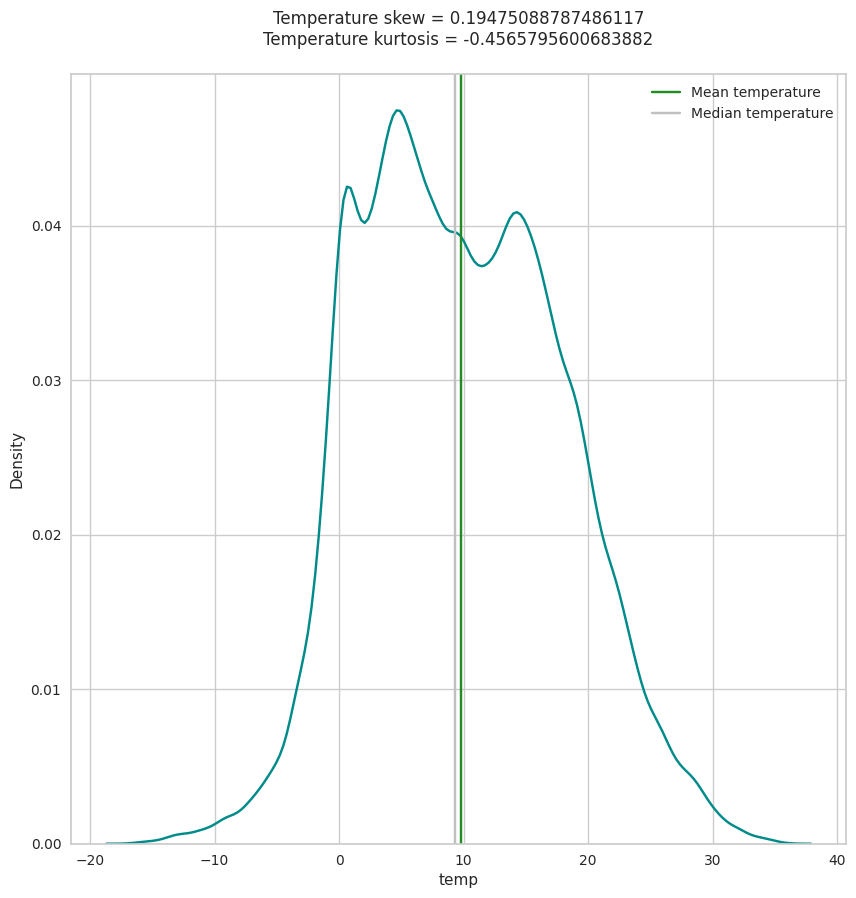

In [8]:
temp_distribution = f"Temperature skew = {df['temp'].skew()}\n" + f"Temperature kurtosis = {df['temp'].kurtosis()}\n"

fig, ax = plt.subplots(figsize = (10,10))

sns.kdeplot(data = df['temp'], color = 'DarkCyan', ax = ax).set_title(temp_distribution)

ax.axvline(x = df['temp'].mean(), color = 'ForestGreen', label = 'Mean temperature')
ax.axvline(x = df['temp'].median(), color = 'Silver', label = 'Median temperature')

plt.legend()

plt.show()

A partir do gráfico acima é possível notar uma leve assimetria, com uma cauda direita na distribuição, indicada ainda pelo valor "skew" ser maior do que zero. 
Pelo coeficiente de curtose, concluí-se que a distribuição é leptocúrtica, sendo mais concentrada que uma distribuição normal

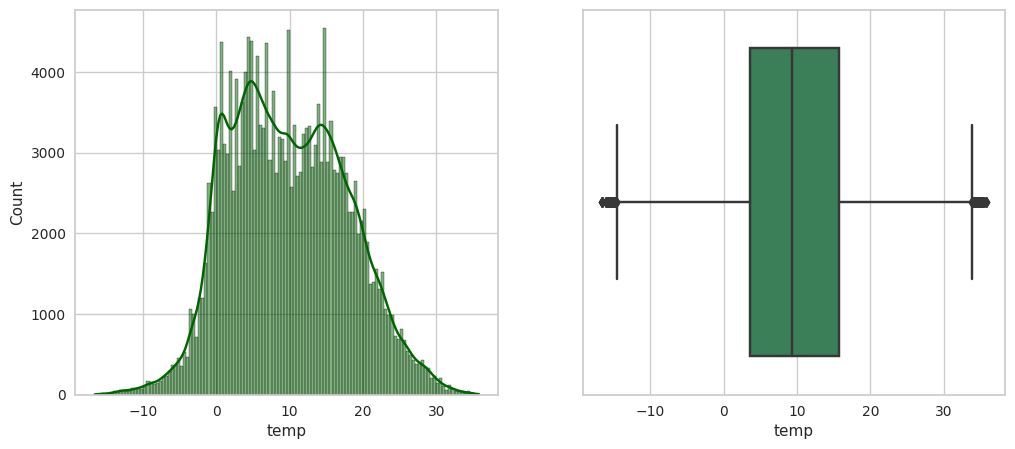

In [9]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

sns.histplot(data = df['temp'], color = 'DarkGreen', kde = True, ax = axes[0])

sns.boxplot(x = df['temp'], color = 'SeaGreen', ax = axes[1])

plt.show()

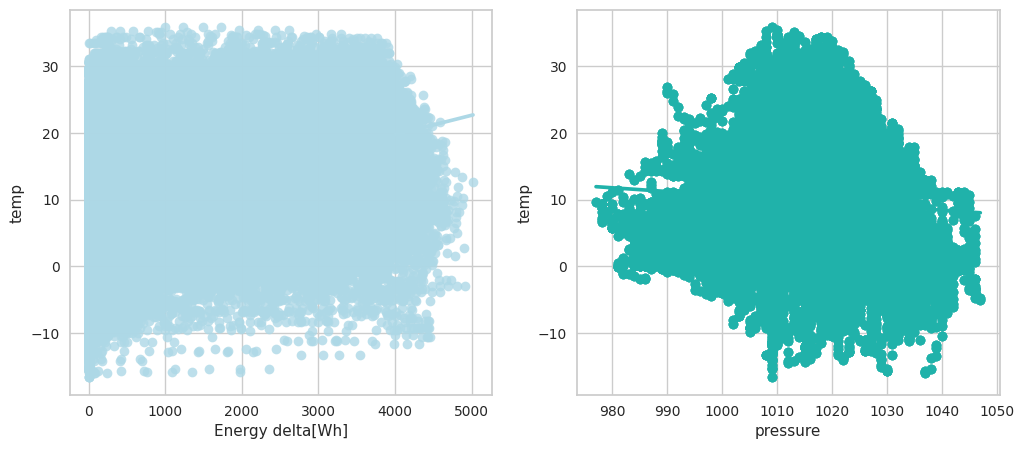

In [10]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

sns.regplot(data = df, 
            x = 'Energy delta[Wh]', 
            y = 'temp', 
            ax = axes[0],
            color = 'LightBlue'
           )

sns.regplot(data = df, 
           x = 'pressure', 
           y = 'temp', 
           ax = axes[1],
           color = 'LightSeaGreen'
          )

plt.show()

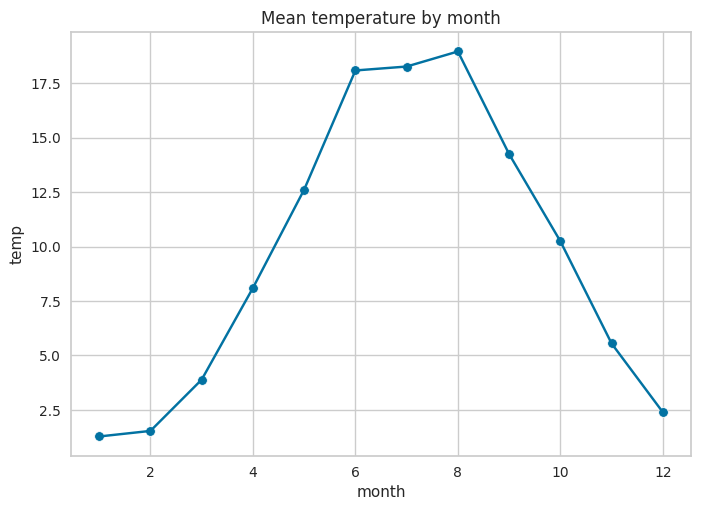

In [11]:
mean_temp_by_month = df.groupby('month')[['temp']].mean()

sns.scatterplot(x = mean_temp_by_month.index, 
                y = mean_temp_by_month.temp
               )

sns.lineplot(x = mean_temp_by_month.index, 
             y = mean_temp_by_month.temp
            ).set_title('Mean temperature by month')

plt.show()

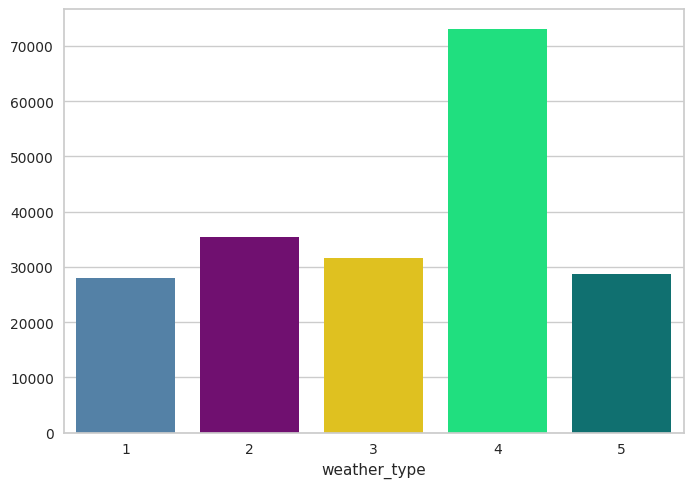

In [12]:
weather_type_counts = df['weather_type'].value_counts()

sns.barplot(x = weather_type_counts.index, 
            y = weather_type_counts.values, 
            palette = ['steelblue', 'purple', 'gold', 'springgreen', 'teal']
           )

plt.show()

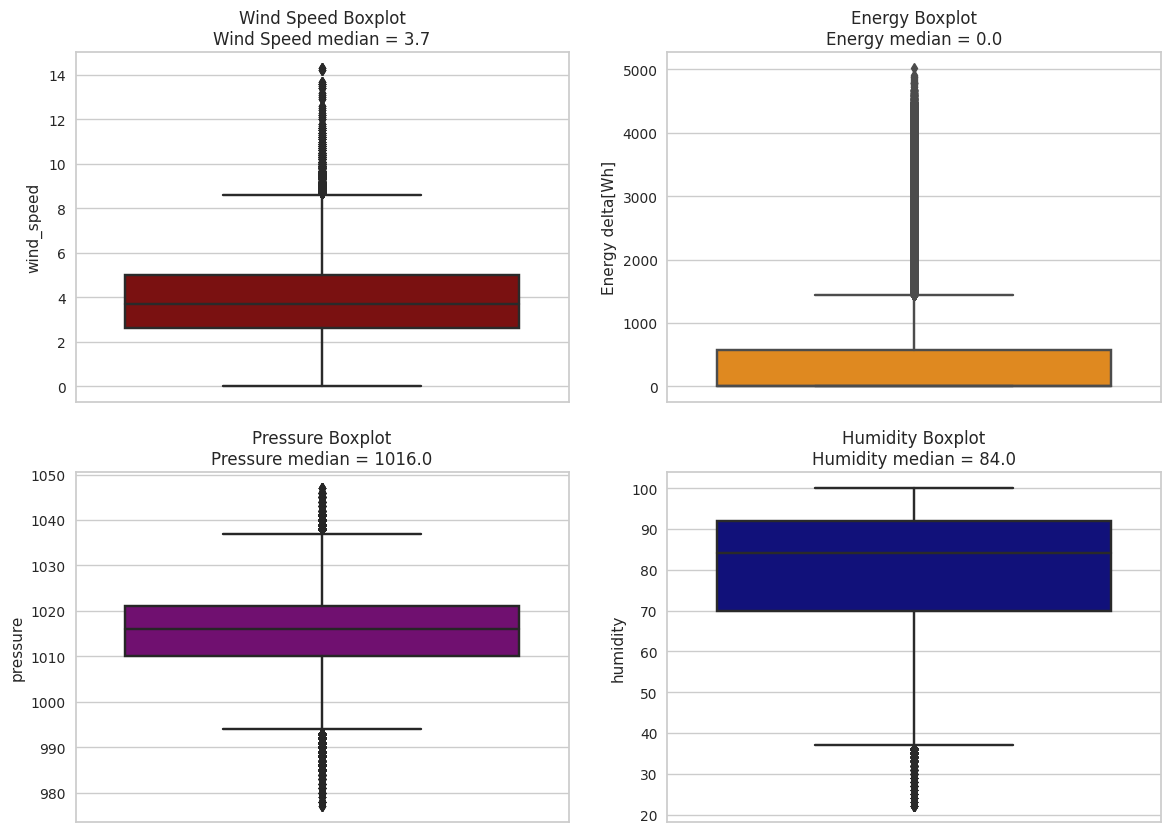

In [13]:
fig, axes = plt.subplots(2, 2, figsize = (14, 10))

wind_speed_title = f"Wind Speed Boxplot\nWind Speed median = {df['wind_speed'].median()}"
sns.boxplot(data = df, y = 'wind_speed', color = 'DarkRed', ax = axes[0][0]).set_title(wind_speed_title)

energy_title = f"Energy Boxplot\nEnergy median = {df['Energy delta[Wh]'].median()}"
sns.boxplot(data = df, y = 'Energy delta[Wh]', color = 'DarkOrange', ax = axes[0][1]).set_title(energy_title)

pressure_title = f"Pressure Boxplot\nPressure median = {df['pressure'].median()}"
sns.boxplot(data = df, y = 'pressure', color = 'Purple', ax = axes[1][0]).set_title(pressure_title)

humidity_title = f"Humidity Boxplot\nHumidity median = {df['humidity'].median()}"
sns.boxplot(data = df, y = 'humidity', color = 'DarkBlue', ax = axes[1][1]).set_title(humidity_title)

plt.show()

In [14]:
numeric_features = df.drop(columns = ['isSun', 'weather_type'])

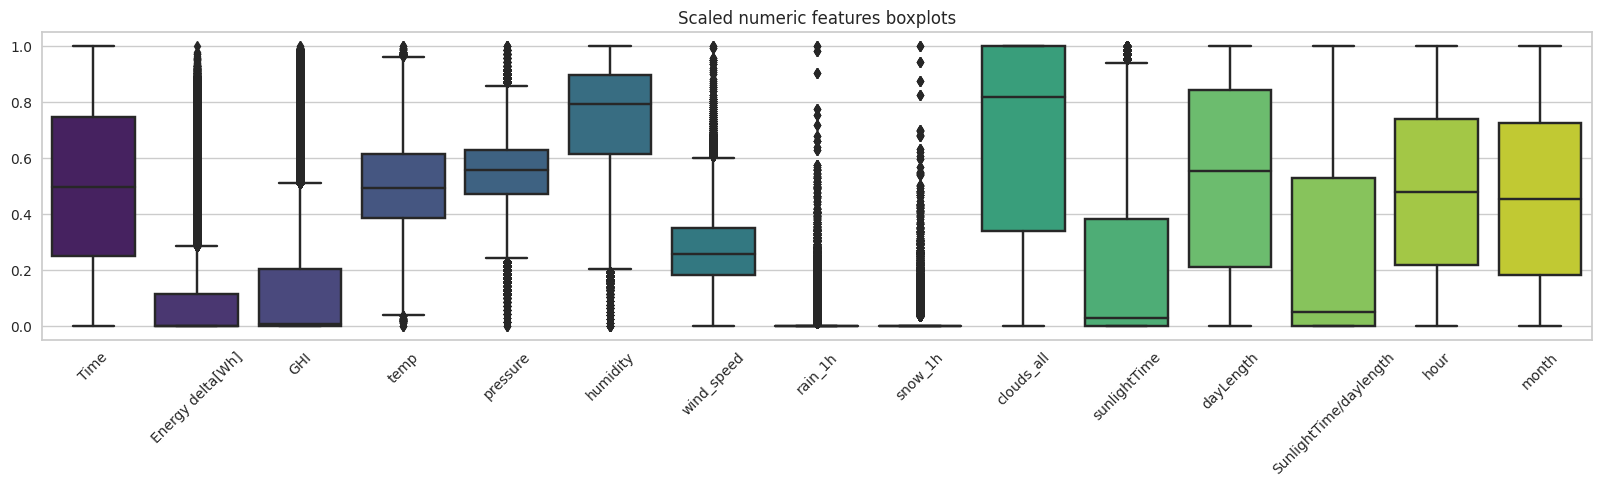

In [15]:
numeric_data = numeric_features.copy()

for feature in numeric_data.columns:
    numeric_data[feature] -= np.min(numeric_data[feature])
    numeric_data[feature] /= np.max(numeric_data[feature])

fig, ax = plt.subplots(figsize = (20, 4))
    
sns.boxplot(data = numeric_data, palette = "viridis").set_title("Scaled numeric features boxplots")

plt.xticks(rotation = 45)

plt.show()

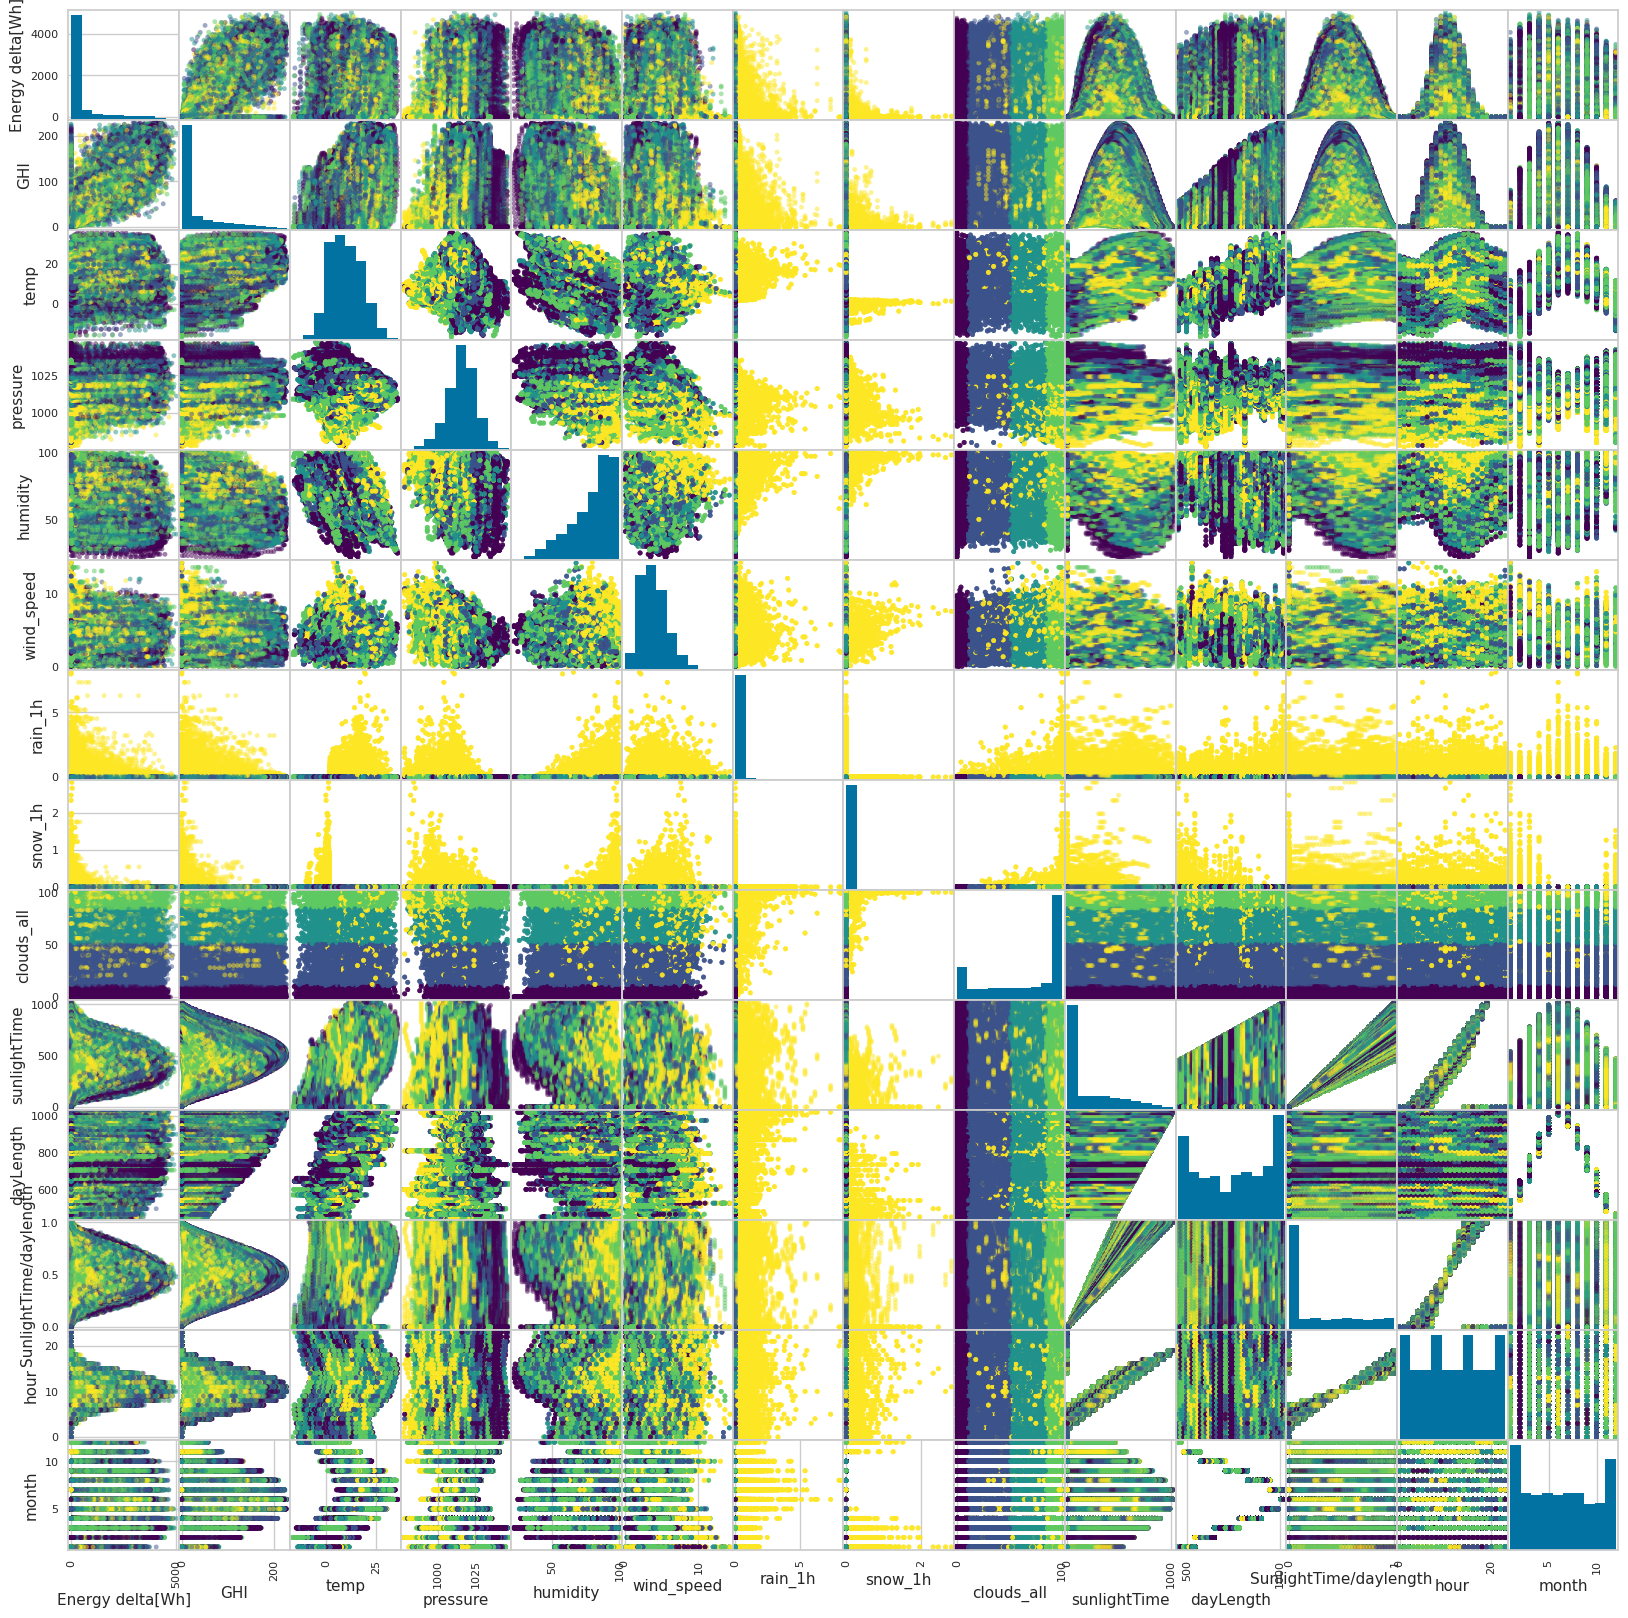

In [16]:
pd.plotting.scatter_matrix(numeric_features, c = df['weather_type'], figsize = (20, 20), cmap = 'viridis')

plt.show()

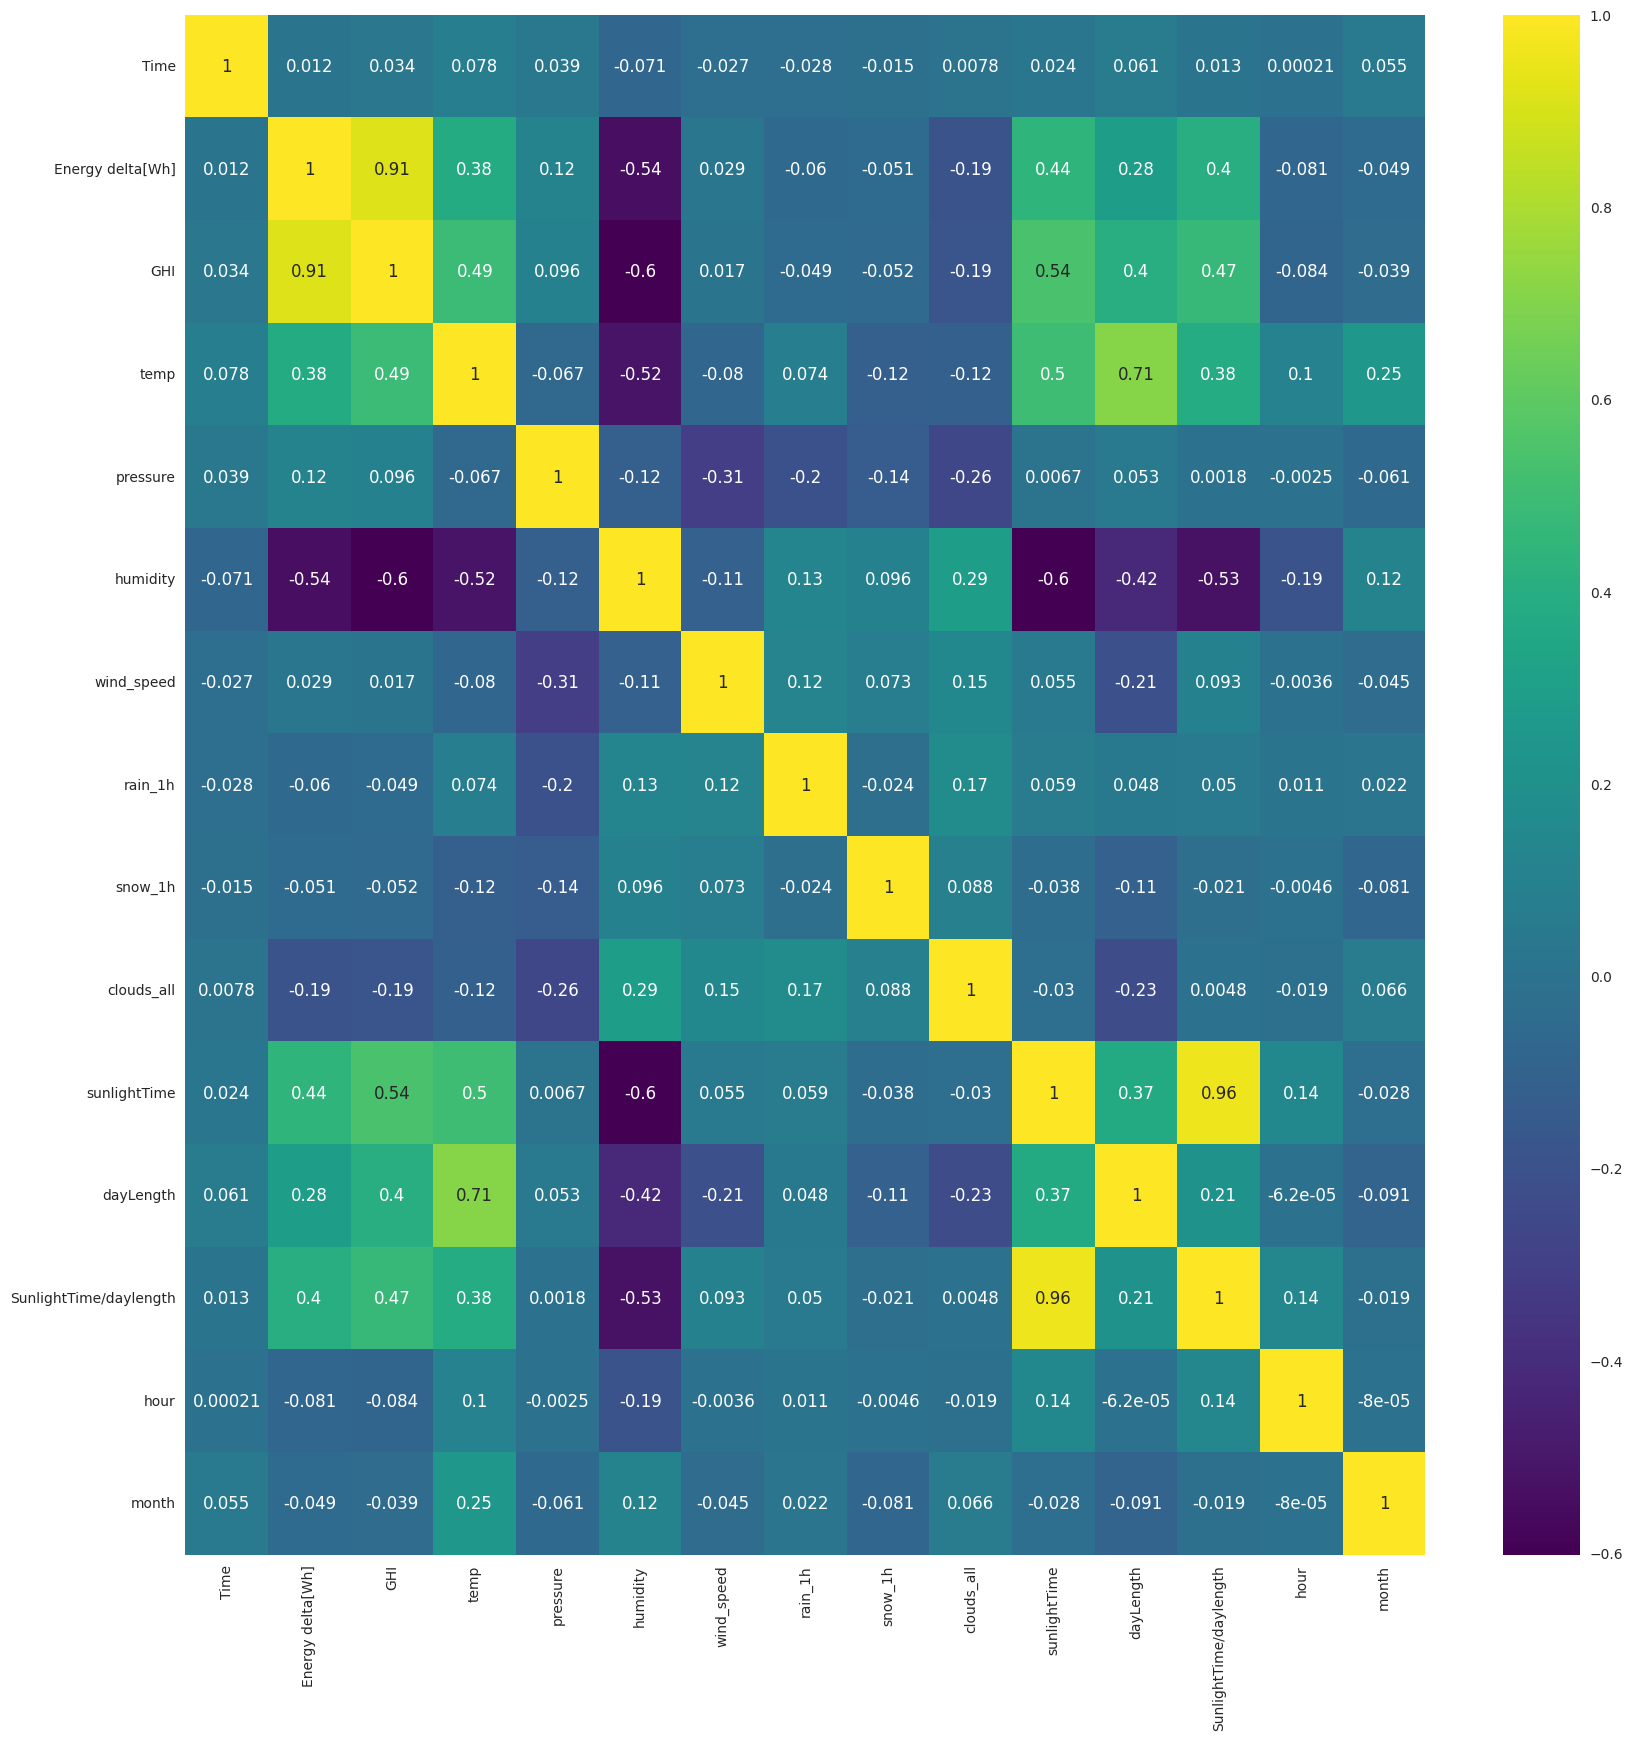

In [17]:
fig, ax = plt.subplots(figsize = (20,20))
sns.heatmap(numeric_features.corr(), annot = True, cmap = 'viridis')
plt.show()

O heatmap acima indica a correlação, usando o método de Pearson, entre os atributos numéricos do dataset. A partir do gráfico, é possível observar uma forte correlação positiva entre a energia produzida e o GHI (global horizontal irradiance).<br> 
Por outro lado, nota-se também uma forte correlação negativa entre o tempo de luminosidade e a humidade.

## Regressão: Target de Temperatura

In [18]:
X = df.drop(columns = ['temp', 'Time'])
y = df['temp']

In [19]:
numeric_X_features = ['Energy delta[Wh]', 'GHI', 'pressure', 'humidity',
       'wind_speed', 'rain_1h', 'snow_1h', 'clouds_all',
       'sunlightTime', 'dayLength', 'SunlightTime/daylength',
       'hour', 'month']

categorical_X_features = ['weather_type']

In [20]:
preprocessor = ColumnTransformer(transformers = 
                                    [("numeric", StandardScaler(), numeric_X_features),
                                     ("categorical", OneHotEncoder(handle_unknown = "ignore"), categorical_X_features)]
                                ) 

In [21]:
train_X, test_X, train_y, test_y = train_test_split(X, y, 
                                                    test_size = 0.6, 
                                                    random_state = 42
                                                   )

print(f"X Train shape = {train_X.shape}")
print(f"y Train shape = {train_y.shape}")
print(f"X Test shape = {test_X.shape}")
print(f"y Test shape = {test_y.shape}")

X Train shape = (78710, 15)
y Train shape = (78710,)
X Test shape = (118066, 15)
y Test shape = (118066,)


In [22]:
rlinear = Pipeline([('preprocessor', preprocessor),
                    ('linear_reg', LinearRegression())
                   ])

rlinear.fit(train_X, train_y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['Energy delta[Wh]', 'GHI',
                                                   'pressure', 'humidity',
                                                   'wind_speed', 'rain_1h',
                                                   'snow_1h', 'clouds_all',
                                                   'sunlightTime', 'dayLength',
                                                   'SunlightTime/daylength',
                                                   'hour', 'month']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['weather_type'])])),
                ('linear_reg', LinearRegression())])

In [23]:
print(f"Linear regression train r2 score = {rlinear.score(train_X, train_y)}")
print(f"Linear regression test r2 score = {rlinear.score(test_X, test_y)}")

Linear regression train r2 score = 0.7178712660677808
Linear regression test r2 score = 0.7178283327939523


In [24]:
linear_scores = cross_val_score(Pipeline([('preprocessor', preprocessor), 
                                          ('linear_reg', LinearRegression())
                                         ]), 
                                X, y, cv = 5, n_jobs = 4
                               )

In [25]:
print(f"Cross val scores for linear regression = {linear_scores}")
print(f"Mean cross val scores = {linear_scores.mean()}")
print(f"Cross val scores standard deviation = {linear_scores.std()}")

Cross val scores for linear regression = [0.74402382 0.71533643 0.61559742 0.72891572 0.70780119]
Mean cross val scores = 0.7023349166299326
Cross val scores standard deviation = 0.0450928293101272


In [26]:
poly_reg2 = Pipeline([('preprocessor', preprocessor),
                     ('polynomial_transform', PolynomialFeatures(degree = 2)),
                     ('linear_reg', LinearRegression())
                   ])

poly_reg2.fit(train_X, train_y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['Energy delta[Wh]', 'GHI',
                                                   'pressure', 'humidity',
                                                   'wind_speed', 'rain_1h',
                                                   'snow_1h', 'clouds_all',
                                                   'sunlightTime', 'dayLength',
                                                   'SunlightTime/daylength',
                                                   'hour', 'month']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['weather_type'])])),
                ('polynomial_transform', PolynomialFeatures()),
                ('linear_reg', LinearRegression())])

In [27]:
print(f"Degree 2 Polynomial regression train r2 score = {poly_reg2.score(train_X, train_y)}")
print(f"Degree 2 Polynomial regression test r2 score = {poly_reg2.score(test_X, test_y)}")

Degree 2 Polynomial regression train r2 score = 0.8339070281286307
Degree 2 Polynomial regression test r2 score = 0.8346486791552559


In [28]:
poly_reg3 = Pipeline([('preprocessor', preprocessor),
                      ('polynomial_transform', PolynomialFeatures(degree = 3)),
                      ('linear_reg', LinearRegression())
                    ])

poly_reg3.fit(train_X, train_y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['Energy delta[Wh]', 'GHI',
                                                   'pressure', 'humidity',
                                                   'wind_speed', 'rain_1h',
                                                   'snow_1h', 'clouds_all',
                                                   'sunlightTime', 'dayLength',
                                                   'SunlightTime/daylength',
                                                   'hour', 'month']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['weather_type'])])),
                ('polynomial_transform', PolynomialFeatures(degree=3)),
                ('linear_reg', LinearRegression())])

In [29]:
print(f"Degree 3 Polynomial regression train r2 score = {poly_reg3.score(train_X, train_y)}")
print(f"Degree 3 Polynomial regression test r2 score = {poly_reg3.score(test_X, test_y)}")

Degree 3 Polynomial regression train r2 score = 0.8526758894079711
Degree 3 Polynomial regression test r2 score = 0.8504307398275244


In [30]:
poly_reg4 = Pipeline([('preprocessor', preprocessor),
                      ('polynomial_transform', PolynomialFeatures(degree = 4)),
                      ('linear_reg', LinearRegression())
                    ])

poly_reg4.fit(train_X, train_y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['Energy delta[Wh]', 'GHI',
                                                   'pressure', 'humidity',
                                                   'wind_speed', 'rain_1h',
                                                   'snow_1h', 'clouds_all',
                                                   'sunlightTime', 'dayLength',
                                                   'SunlightTime/daylength',
                                                   'hour', 'month']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['weather_type'])])),
                ('polynomial_transform', PolynomialFeatures(degree=4)),
                ('linear_reg', LinearRegression())])

In [31]:
print(f"Degree 4 Polynomial regression train r2 score = {poly_reg4.score(train_X, train_y)}")
print(f"Degree 4 Polynomial regression test r2 score = {poly_reg4.score(test_X, test_y)}")

Degree 4 Polynomial regression train r2 score = 0.8774541878265145
Degree 4 Polynomial regression test r2 score = 0.81799496507474


In [32]:
ridge_grid_param = {'ridge__alpha': [0.01, 0.1, 1, 10, 100]} 

ridge_pipe = Pipeline([('preprocessor', preprocessor), ('ridge', Ridge())])

ridge = GridSearchCV(ridge_pipe, ridge_grid_param, cv = 5)

ridge.fit(train_X, train_y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         StandardScaler(),
                                                                         ['Energy '
                                                                          'delta[Wh]',
                                                                          'GHI',
                                                                          'pressure',
                                                                          'humidity',
                                                                          'wind_speed',
                                                                          'rain_1h',
                                                                          'snow_1h',
                                                                          'clouds_all',
                                                                          'sunlightTime',
                                                                          'dayLength',
                                                                          'SunlightTime/daylength',
                                                                          'hour',
                                                                          'month']),
                                                                        ('categorical',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['weather_type'])])),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': [0.01, 0.1, 1, 10, 100]})

In [33]:
print(f"Ridge train r2 score = {ridge.score(train_X, train_y)}")
print(f"Ridge test r2 score = {ridge.score(test_X, test_y)}")

Ridge train r2 score = 0.7178712364927125
Ridge test r2 score = 0.7178281845099936


In [34]:
print(f"Best parameter for ridge = {ridge.best_estimator_.named_steps['ridge']}")

Best parameter for ridge = Ridge(alpha=10)


In [35]:
elastic_net = Pipeline([('preprocessor', preprocessor), 
                        ('elast_net', ElasticNet(random_state = 42, alpha = 0.001))
                       ])

elastic_net.fit(train_X, train_y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['Energy delta[Wh]', 'GHI',
                                                   'pressure', 'humidity',
                                                   'wind_speed', 'rain_1h',
                                                   'snow_1h', 'clouds_all',
                                                   'sunlightTime', 'dayLength',
                                                   'SunlightTime/daylength',
                                                   'hour', 'month']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['weather_type'])])),
                ('elast_net', ElasticNet(alpha=0.001, random_state=42))])

In [36]:
print(f"Elastic Net train r2 score = {elastic_net.score(train_X, train_y)}")
print(f"Elastic Net test r2 score = {elastic_net.score(test_X, test_y)}")

Elastic Net train r2 score = 0.7178680441454018
Elastic Net test r2 score = 0.7178211919370987


In [37]:
elastic_scores = cross_val_score(Pipeline([('preprocessor', preprocessor), 
                                           ('elast_net', ElasticNet(random_state = 42, alpha = 0.001))
                                          ]),
                                 X, y, cv = 5, n_jobs = 4
                                )

In [38]:
print(f"Cross val scores for elastic net = {elastic_scores}")
print(f"Mean cross val scores = {elastic_scores.mean()}")
print(f"Cross val scores standard deviation = {elastic_scores.std()}")

Cross val scores for elastic net = [0.7440802  0.71521398 0.61579891 0.72888319 0.70780381]
Mean cross val scores = 0.7023560177999532
Cross val scores standard deviation = 0.045014969517455046


In [39]:
svr = Pipeline([('preprocessor', preprocessor), ('svr', SVR(C = 100, gamma = 0.01))])

svr.fit(train_X, train_y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['Energy delta[Wh]', 'GHI',
                                                   'pressure', 'humidity',
                                                   'wind_speed', 'rain_1h',
                                                   'snow_1h', 'clouds_all',
                                                   'sunlightTime', 'dayLength',
                                                   'SunlightTime/daylength',
                                                   'hour', 'month']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['weather_type'])])),
                ('svr', SVR(C=100, gamma=0.01))])

In [40]:
print(f"SVR train r2 score = {svr.score(train_X, train_y)}")
print(f"SVR test r2 score = {svr.score(test_X, test_y)}")

SVR train r2 score = 0.8460839490992615
SVR test r2 score = 0.8468585789758777


In [41]:
tree = DecisionTreeRegressor(max_leaf_nodes = 12, criterion = "squared_error")

tree.fit(train_X, train_y)

DecisionTreeRegressor(max_leaf_nodes=12)

In [42]:
print(f"Decision Tree train r2 score = {tree.score(train_X, train_y)}")
print(f"Decision Tree test r2 score = {tree.score(test_X, test_y)}")

Decision Tree train r2 score = 0.7472536574701789
Decision Tree test r2 score = 0.7477450302651389


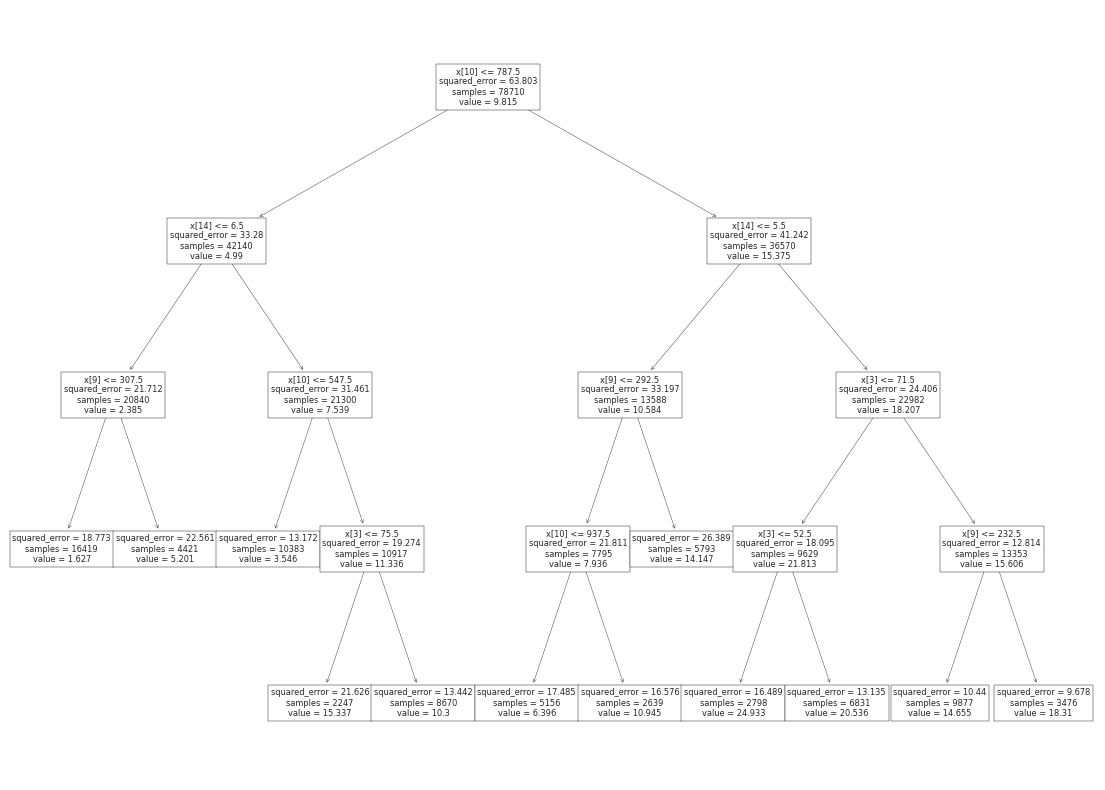

In [43]:
fig, ax = plt.subplots(figsize = (14, 10))
plot_tree(tree)
plt.show()

In [44]:
tree_scores = cross_val_score(DecisionTreeRegressor(max_leaf_nodes = 584), 
                              X, y, cv = 5, n_jobs = 4)

In [45]:
print(f'Decision Tree scores = {tree_scores}')
print(f'Mean score = {tree_scores.mean()}')
print(f'SD score = {tree_scores.std()}')

Decision Tree scores = [0.75657003 0.70915824 0.71137018 0.78593865 0.78160908]
Mean score = 0.7489292377576193
SD score = 0.033131452491977166


In [46]:
tree_grid_param = {'max_leaf_nodes': [104, 314, 584, 954, 1354], 
                   'criterion': ['squared_error']
                  } 


grid_tree = GridSearchCV(DecisionTreeRegressor(), tree_grid_param, cv = 5, n_jobs = 4)

grid_tree.fit(train_X, train_y)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=4,
             param_grid={'criterion': ['squared_error'],
                         'max_leaf_nodes': [104, 314, 584, 954, 1354]})

In [47]:
print(f"Gridge Decision Tree train r2 score = {grid_tree.score(train_X, train_y)}")
print(f"Gridge Decision Tree test r2 score = {grid_tree.score(test_X, test_y)}")

Gridge Decision Tree train r2 score = 0.919489702836713
Gridge Decision Tree test r2 score = 0.8987020811505249


In [48]:
print(f"Best parameter for Decision Tree = {grid_tree.best_estimator_}")

Best parameter for Decision Tree = DecisionTreeRegressor(max_leaf_nodes=1354)


In [49]:
forest = RandomForestRegressor(random_state = 42, 
                               n_estimators = 154, 
                               max_leaf_nodes = 704, 
                               n_jobs = 2 
                              )

forest.fit(train_X, train_y)

RandomForestRegressor(max_leaf_nodes=704, n_estimators=154, n_jobs=2,
                      random_state=42)

In [50]:
print(f"Random forest train r2 score = {forest.score(train_X, train_y)}")
print(f"Random forest test r2 score = {forest.score(test_X, test_y)}")

Random forest train r2 score = 0.9161730208976073
Random forest test r2 score = 0.9058999746259274


In [51]:
forest_scores = cross_val_score(RandomForestRegressor(random_state = 42, 
                                                      n_estimators = 154, 
                                                      max_leaf_nodes = 704
                                                     ), 
                                X, y, cv = 5, n_jobs = 4
                               )

In [52]:
print(f"Cross val scores for random forest = {forest_scores}")
print(f"Mean cross val scores = {forest_scores.mean()}")
print(f"Cross val scores standard deviation = {forest_scores.std()}")

Cross val scores for random forest = [0.79657589 0.74183204 0.73982667 0.816772   0.81445509]
Mean cross val scores = 0.7818923367020263
Cross val scores standard deviation = 0.03425457039998023


In [53]:
histboost = HistGradientBoostingRegressor(random_state = 42, 
                                          learning_rate = 0.11, 
                                          max_leaf_nodes = 38, 
                                          scoring = "r2"
                                         )

histboost.fit(train_X, train_y)

HistGradientBoostingRegressor(learning_rate=0.11, max_leaf_nodes=38,
                              random_state=42, scoring='r2')

In [54]:
print(f"Histogram Gradient Boosting train r2 score = {histboost.score(train_X, train_y)}")
print(f"Histogram Gradient Boosting test r2 score = {histboost.score(test_X, test_y)}")

Histogram Gradient Boosting train r2 score = 0.8991882170948482
Histogram Gradient Boosting test r2 score = 0.8936883534481503


In [55]:
histboost_scores = cross_val_score(HistGradientBoostingRegressor(random_state = 42, 
                                                                 learning_rate = 0.11, 
                                                                 max_leaf_nodes = 38, 
                                                                 scoring = "r2"
                                                                ),
                                   X, y, cv = 5, n_jobs = 4
                                  )

In [56]:
print(f"Cross val scores for Histogram Gradient Boosting = {histboost_scores}")
print(f"Mean cross val scores = {histboost_scores.mean()}")
print(f"Cross val scores standard deviation = {histboost_scores.std()}")

Cross val scores for Histogram Gradient Boosting = [0.84120649 0.7633031  0.77418261 0.82822045 0.84447287]
Mean cross val scores = 0.8102771033209641
Cross val scores standard deviation = 0.0345175634479042


In [57]:
lgbr_X = X.copy()

lgbr_X = lgbr_X.rename(columns = lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

lgbr_train_X, lgbr_test_X, lgbr_train_y, lgbr_test_y = train_test_split(lgbr_X, y, 
                                                                        random_state = 42, 
                                                                        test_size = 0.6
                                                                       ) 

In [58]:
lgbmr = LGBMRegressor(n_estimators = 674,
                      max_depth = 21, 
                      learning_rate = 0.12, 
                      num_leaves = 32 
                     )

lgbmr.fit(lgbr_train_X, lgbr_train_y)

LGBMRegressor(learning_rate=0.12, max_depth=21, n_estimators=674, num_leaves=32)

In [59]:
print(f"LGBM train r2 score = {lgbmr.score(lgbr_train_X, lgbr_train_y)}")
print(f"LGBM test r2 score = {lgbmr.score(lgbr_test_X, lgbr_test_y)}")

LGBM train r2 score = 0.9512374568227118
LGBM test r2 score = 0.9365342206259903


In [60]:
lgbmr_scores = cross_val_score(LGBMRegressor(n_estimators = 674,
                                             max_depth = 21, 
                                             learning_rate = 0.12, 
                                             num_leaves = 32 
                                            ), 
                               lgbr_X, y,
                               cv = 5,
                               n_jobs = 4
                              )

In [61]:
print(f"LGBM scores = {lgbmr_scores}")
print(f"LGBM mean score = {lgbmr_scores.mean()}")
print(f"LGBM score standard deviation = {lgbmr_scores.std()}")

LGBM scores = [0.82632032 0.75787475 0.75514922 0.81755174 0.83633616]
LGBM mean score = 0.7986464368018498
LGBM score standard deviation = 0.03492307915903543


In [62]:
xgbr = Pipeline([
         ('scaler', StandardScaler()),
         ('xgbr', XGBRegressor(random_state = 1,
                               n_estimators = 200, 
                               learning_rate = 0.1,
                               base_score = 0.5
                              )
         ) 
        ])

xgbr.fit(train_X, train_y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('xgbr',
                 XGBRegressor(base_score=0.5, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, gpu_id=None,
                              grow_policy=None, importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, n_estimators=200,
                              n_jobs=None, num_parallel_tree=None,
                              predictor=None, random_state=1, ...))])

In [63]:
print(f"XGBoost train r2 score = {xgbr.score(train_X, train_y)}")
print(f"XGBoost test r2 score = {xgbr.score(test_X, test_y)}")

XGBoost train r2 score = 0.9143454521615716
XGBoost test r2 score = 0.9059562649877124


In [64]:
xgbr_scores = cross_val_score(
                Pipeline([
                    ('scaler', StandardScaler()),
                    ('xgbr', XGBRegressor(random_state = 1,
                                          n_estimators = 200, 
                                          learning_rate = 0.1,
                                          base_score = 0.5
                                         ))
                ]), X, y, cv = 5, n_jobs = 2
              )

In [65]:
print(f"Cross val scores for XGBoost = {xgbr_scores}")
print(f"Mean cross val scores = {xgbr_scores.mean()}")
print(f"Cross val scores standard deviation = {xgbr_scores.std()}")

Cross val scores for XGBoost = [0.83538042 0.75971684 0.76806348 0.82615629 0.83790243]
Mean cross val scores = 0.8054438895898197
Cross val scores standard deviation = 0.03425496917039167


In [66]:
scaler = StandardScaler().fit(train_X)

train_X_scaled = scaler.transform(train_X)
test_X_scaled = scaler.transform(test_X)

In [67]:
neural_net = tf.keras.Sequential([
                layers.Dense(128, input_shape = [train_X_scaled.shape[1]], activation = 'relu'),
                layers.Dense(16, activation = 'relu'),
                layers.Dense(8),
                layers.Dense(1)
             ])

In [68]:
neural_net.compile(optimizer = 'adam',
                   loss = 'mse',
                   metrics = ['mean_absolute_error']
                  )

In [69]:
history = neural_net.fit(train_X_scaled, 
                         train_y, 
                         validation_data = (test_X_scaled, test_y),
                         epochs = 14
                        )

Epoch 1/14
2460/2460 [==============================] - 11s 4ms/step - loss: 13.8997 - mean_absolute_error: 2.7782 - val_loss: 10.4792 - val_mean_absolute_error: 2.5082
Epoch 2/14
2460/2460 [==============================] - 10s 4ms/step - loss: 10.2245 - mean_absolute_error: 2.4710 - val_loss: 9.7941 - val_mean_absolute_error: 2.4205
Epoch 3/14
2460/2460 [==============================] - 10s 4ms/step - loss: 9.8868 - mean_absolute_error: 2.4295 - val_loss: 9.7217 - val_mean_absolute_error: 2.4145
Epoch 4/14
2460/2460 [==============================] - 10s 4ms/step - loss: 9.6414 - mean_absolute_error: 2.4010 - val_loss: 9.4784 - val_mean_absolute_error: 2.3805
Epoch 5/14
2460/2460 [==============================] - 10s 4ms/step - loss: 9.4439 - mean_absolute_error: 2.3762 - val_loss: 9.4571 - val_mean_absolute_error: 2.3667
Epoch 6/14
2460/2460 [==============================] - 10s 4ms/step - loss: 9.2903 - mean_absolute_error: 2.3564 - val_loss: 9.2771 - val_mean_absolute_error: 2.

In [70]:
history_df = pd.DataFrame(history.history)

display(history_df.head())

loss  mean_absolute_error   val_loss  val_mean_absolute_error
0  13.899744             2.778218  10.479248                 2.508172
1  10.224466             2.470971   9.794093                 2.420526
2   9.886773             2.429451   9.721728                 2.414476
3   9.641450             2.400975   9.478392                 2.380517
4   9.443910             2.376218   9.457093                 2.366668

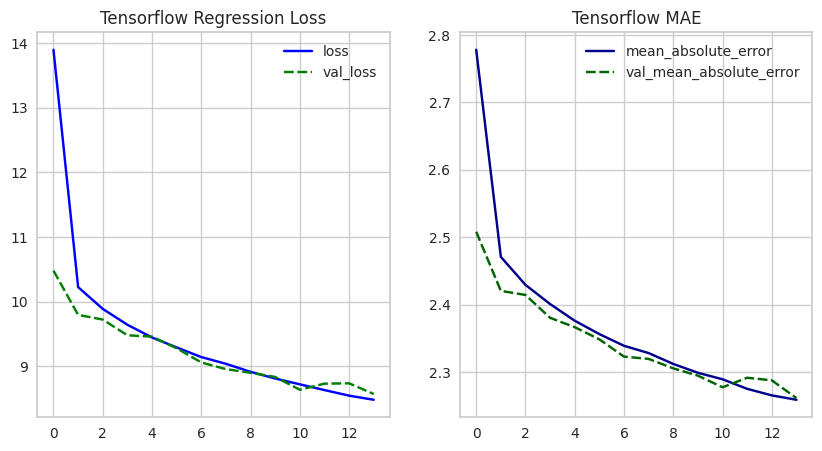

In [71]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))

sns.lineplot(history_df.loc[:, ['loss', 'val_loss']], 
             ax = axes[0], 
             palette = ['Blue', 'Green']
            ).set(title = "Tensorflow Regression Loss")

sns.lineplot(history_df.loc[:, ['mean_absolute_error', 'val_mean_absolute_error']], 
             ax = axes[1], 
             palette = ['DarkBlue', 'DarkGreen']
            ).set(title = "Tensorflow MAE")

plt.show()

In [72]:
predict_train_y = neural_net.predict(train_X_scaled) 
predict_y = neural_net.predict(test_X_scaled)

3690/3690 [==============================] - 5s 1ms/step


In [73]:
print(f"Neural Network train r2 score = {r2_score(predict_train_y, train_y)}")
print(f"Neural Network test r2 score = {r2_score(predict_y, test_y)}")

Neural Network train r2 score = 0.8388861157121578
Neural Network test r2 score = 0.8327431065939452


In [74]:
nn_X = X.copy()

nn_X = pd.DataFrame(preprocessor.fit_transform(nn_X))

In [75]:
early_stopping = callbacks.EarlyStopping(patience = 5)

In [76]:
model = tf.keras.Sequential([
                layers.Dense(256, input_shape = [nn_X.shape[1]], activation = 'relu'),
                layers.Dense(128, activation = 'relu'),
                layers.Dense(64, activation = 'relu'),
                layers.Dense(64, activation = 'relu'),
                layers.Dense(16),
                layers.Dense(1)
        ])

model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])

scikeras_model = KerasRegressor(model, 
                                callbacks = [early_stopping], 
                                epochs = 424, 
                                batch_size = 64,
                                verbose = 0
                               )

nn_X_train, nn_X_test, nn_y_train, nn_y_test = train_test_split(nn_X, y, 
                                                                random_state = 1, 
                                                                test_size= 0.6
                                                               )

hist = scikeras_model.fit(nn_X_train, nn_y_train)

nn_y_tr_pred = scikeras_model.predict(nn_X_train)
nn_y_ts_pred = scikeras_model.predict(nn_X_test)

print(f"Neural Network train r2 score = {r2_score(nn_y_tr_pred, nn_y_train)}")
print(f"Neural Network test r2 score = {r2_score(nn_y_ts_pred, nn_y_test)}")

Neural Network train r2 score = 0.9891014491690739
Neural Network test r2 score = 0.9627082800935143


In [77]:
filename = "neural_network"

model.save(f"/kaggle/working/{filename}")

In [78]:
saved_model = tf.keras.models.load_model(f"/kaggle/working/{filename}")

saved_pred = saved_model.predict(nn_X_test)

print(f"Score = {r2_score(saved_pred, nn_y_test)}")

3690/3690 [==============================] - 6s 1ms/step
Score = 0.9627082801029001


In [79]:
model = tf.keras.Sequential([
                layers.Dense(64, input_shape = [nn_X.shape[1]], activation = 'relu'),
                layers.Dense(16, activation = 'relu'),
                layers.Dense(8),
                layers.Dense(1)
        ])

model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])

In [80]:
scikeras_model = KerasRegressor(model, 
                                callbacks = [early_stopping], 
                                epochs = 54, 
                                batch_size = 16,
                                verbose = 0
                               )

In [81]:
neural_net_scores = cross_val_score(scikeras_model, 
                                    nn_X, y, 
                                    cv = 4, n_jobs = 4
                                   )

In [82]:
print(f"Cross val scores for Neural Network = {neural_net_scores}")
print(f"Mean cross val scores = {neural_net_scores.mean()}")
print(f"Cross val scores standard deviation = {neural_net_scores.std()}")

Cross val scores for Neural Network = [0.7657418  0.81132566 0.75952623 0.79251391]
Mean cross val scores = 0.7822768986651711
Cross val scores standard deviation = 0.020854431812820064


In [83]:
X_transformed = pd.DataFrame(preprocessor.fit_transform(X))

In [84]:
X_transformed.columns = numeric_X_features + [f'weather_type{i}' for i in range(1, 6)]

In [85]:
pca = PCA(n_components = 2)
pca.fit(X_transformed)

PCA(n_components=2)

In [86]:
X_pca = pca.transform(X_transformed)

print("Original shape: ", X_transformed.shape)
print("Transformed shape: ", X_pca.shape)

Original shape:  (196776, 18)
Transformed shape:  (196776, 2)


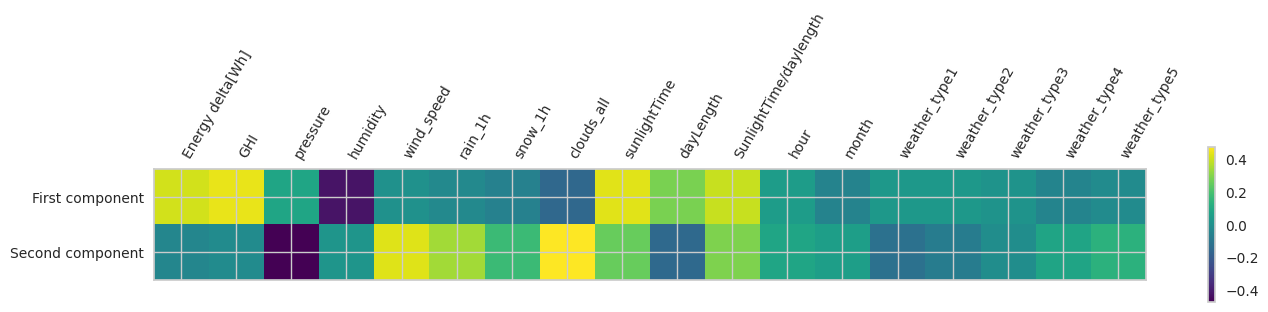

In [87]:
plt.matshow(pca.components_, cmap = 'viridis')
plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(X_transformed.columns)), X_transformed.columns, rotation = 60, ha = 'left')
plt.show()

In [88]:
print(f"Best features by name: {X_transformed.columns[np.argsort(pca.components_[0])][::-1]}\n")
print(f"Best features by importance: {np.sort(pca.components_[0])[::-1]}\n")

Best features by name: Index(['GHI', 'sunlightTime', 'Energy delta[Wh]', 'SunlightTime/daylength',
       'dayLength', 'pressure', 'hour', 'weather_type1', 'weather_type2',
       'weather_type3', 'wind_speed', 'weather_type5', 'rain_1h',
       'weather_type4', 'month', 'snow_1h', 'clouds_all', 'humidity'],
      dtype='object')

Best features by importance: [ 0.44098231  0.42760055  0.40614396  0.39277848  0.28027987  0.08153101
  0.04845876  0.03077497  0.0287489   0.0096723   0.00399285 -0.02009562
 -0.03132621 -0.04910055 -0.0534235  -0.05879497 -0.15580245 -0.42384868]



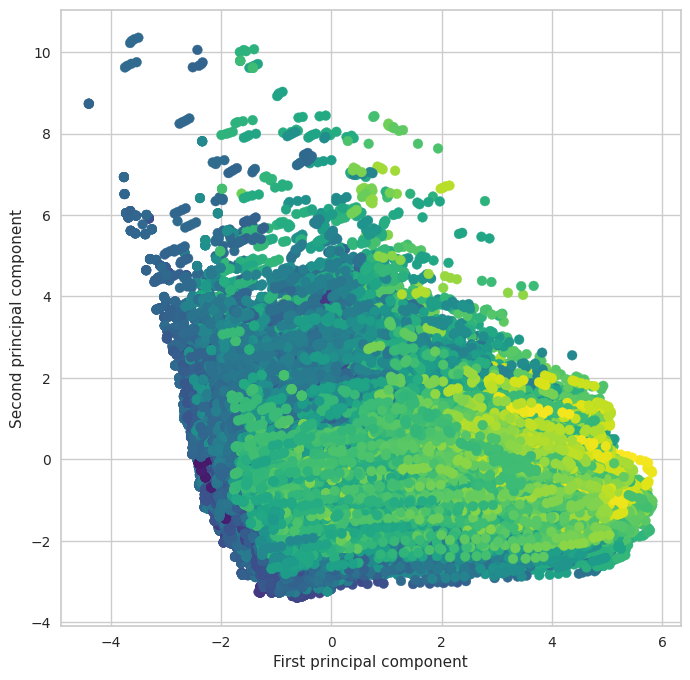

In [89]:
plt.figure(figsize = (8, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c = y, cmap = 'viridis')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.show()

In [90]:
viz = ValidationCurve(
        RandomForestRegressor(random_state = 1), 
        param_name = "max_leaf_nodes",
        param_range = [10**x + 1 for x in range(1, 5)], 
        cv = 4, scoring = "r2",
        logx = True,
        n_jobs = 4
      )

ValidationCurve(ax=<Axes: >, cv=4,
                estimator=RandomForestRegressor(random_state=1), logx=True,
                n_jobs=4, param_name='max_leaf_nodes',
                param_range=array([   11,   101,  1001, 10001]), scoring='r2')

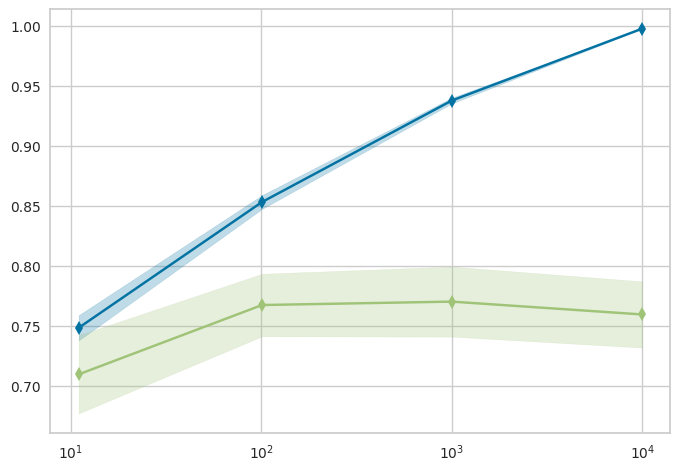

In [91]:
viz.fit(X, y)

## Séries Temporais: Máxima, Mínima e Média diárias de Temperatura

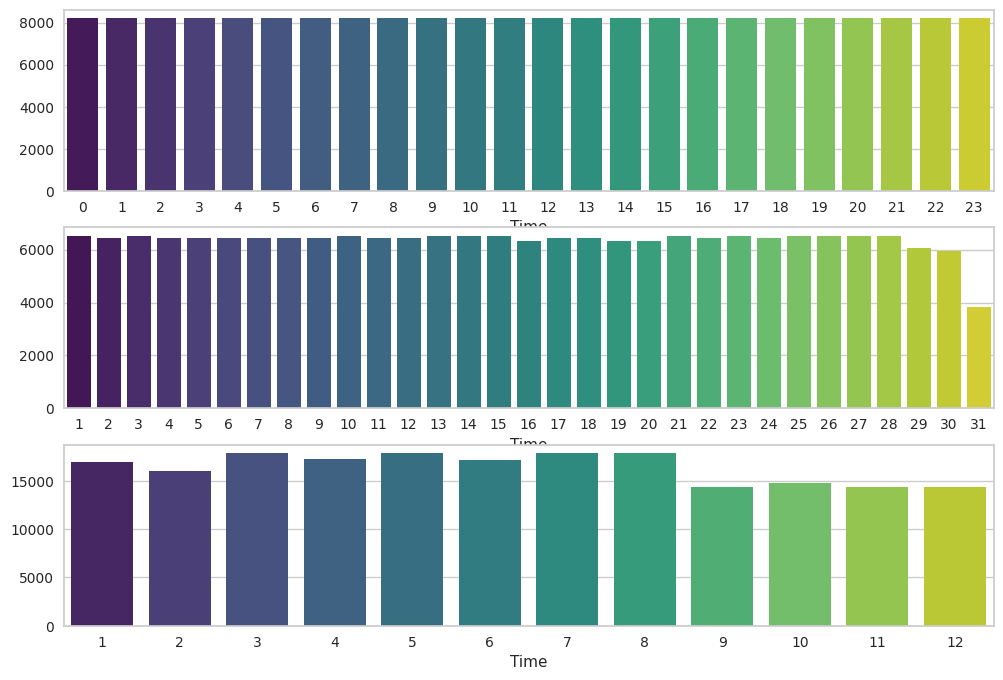

In [92]:
fig, axes = plt.subplots(3, 1, figsize = (12, 8))

hours = df['Time'].dt.hour
count_hours = hours.value_counts()
sns.barplot(x = count_hours.index, y = count_hours.values, ax = axes[0], palette = 'viridis')

days = df['Time'].dt.day
count_days = days.value_counts()
sns.barplot(x = count_days.index, y = count_days.values, ax = axes[1], palette = 'viridis')

months = df['Time'].dt.month
count_months = months.value_counts()
sns.barplot(x = count_months.index, y = count_months.values, ax = axes[2], palette = 'viridis')

plt.show()

In [93]:
ts_df = df[['Time', 'temp', 'Energy delta[Wh]']].copy()

ts_df['date'] = pd.to_datetime(ts_df['Time'].dt.date)

ts_df = ts_df.drop(columns = ['Time'])

display(ts_df.head(10))

temp  Energy delta[Wh]       date
0   1.6                 0 2017-01-01
1   1.6                 0 2017-01-01
2   1.6                 0 2017-01-01
3   1.6                 0 2017-01-01
4   1.7                 0 2017-01-01
5   1.7                 0 2017-01-01
6   1.7                 0 2017-01-01
7   1.7                 0 2017-01-01
8   1.9                 0 2017-01-01
9   1.9                 0 2017-01-01

In [94]:
dates_df = ts_df.groupby(['date'])[['temp']].agg([max, min, np.mean])

dates_df = dates_df.reset_index()

dates_df.columns = ['date', 'max_temp', 'min_temp', 'avg_temp']

dates_df.set_index('date', inplace = True)

display(dates_df)

max_temp  min_temp   avg_temp
date                                     
2017-01-01       3.9       1.6   2.975000
2017-01-02       2.5      -2.2   0.850000
2017-01-03       4.7      -2.3   1.420833
2017-01-04       2.8      -1.3   1.166667
2017-01-10      -2.0      -7.8  -3.854167
...              ...       ...        ...
2022-08-27      26.6      17.1  21.191667
2022-08-28      22.0      13.2  18.829167
2022-08-29      20.8      12.9  16.525000
2022-08-30      19.8      11.6  16.191667
2022-08-31      19.9       8.0  15.161111

[2050 rows x 3 columns]

In [95]:
lagged_df = dates_df.copy()

shifted = 4

cols_X = list()

for feature in lagged_df.columns:
    for lag in range(1, shifted+1):
        lagged_df[f'{feature}_lag{lag}'] = lagged_df[feature].shift(lag)
        cols_X.append(f'{feature}_lag{lag}')

display(lagged_df)

max_temp  min_temp   avg_temp  max_temp_lag1  max_temp_lag2  \
date                                                                      
2017-01-01       3.9       1.6   2.975000            NaN            NaN   
2017-01-02       2.5      -2.2   0.850000            3.9            NaN   
2017-01-03       4.7      -2.3   1.420833            2.5            3.9   
2017-01-04       2.8      -1.3   1.166667            4.7            2.5   
2017-01-10      -2.0      -7.8  -3.854167            2.8            4.7   
...              ...       ...        ...            ...            ...   
2022-08-27      26.6      17.1  21.191667           29.7           26.7   
2022-08-28      22.0      13.2  18.829167           26.6           29.7   
2022-08-29      20.8      12.9  16.525000           22.0           26.6   
2022-08-30      19.8      11.6  16.191667           20.8           22.0   
2022-08-31      19.9       8.0  15.161111           19.8           20.8   

            max_temp_lag3  max_temp_lag4  min_temp_lag1  min_temp_lag2  \
date                                                                     
2017-01-01            NaN            NaN            NaN            NaN   
2017-01-02            NaN            NaN            1.6            NaN   
2017-01-03            NaN            NaN           -2.2            1.6   
2017-01-04            3.9            NaN           -2.3           -2.2   
2017-01-10            2.5            3.9           -1.3           -2.3   
...                   ...            ...            ...            ...   
2022-08-27           23.3           22.7           18.7           17.9   
2022-08-28           26.7           23.3           17.1           18.7   
2022-08-29           29.7           26.7           13.2           17.1   
2022-08-30           26.6           29.7           12.9           13.2   
2022-08-31           22.0           26.6           11.6           12.9   

            min_temp_lag3  min_temp_lag4  avg_temp_lag1  avg_temp_lag2  \
date                                                                     
2017-01-01            NaN            NaN            NaN            NaN   
2017-01-02            NaN            NaN       2.975000            NaN   
2017-01-03            NaN            NaN       0.850000       2.975000   
2017-01-04            1.6            NaN       1.420833       0.850000   
2017-01-10           -2.2            1.6       1.166667       1.420833   
...                   ...            ...            ...            ...   
2022-08-27           17.8           16.7      22.975000      21.783333   
2022-08-28           17.9           17.8      21.191667      22.975000   
2022-08-29           18.7           17.9      18.829167      21.191667   
2022-08-30           17.1           18.7      16.525000      18.829167   
2022-08-31           13.2           17.1      16.191667      16.525000   

            avg_temp_lag3  avg_temp_lag4  
date                                      
2017-01-01            NaN            NaN  
2017-01-02            NaN            NaN  
2017-01-03            NaN            NaN  
2017-01-04       2.975000            NaN  
2017-01-10       0.850000       2.975000  
...                   ...            ...  
2022-08-27      20.437500      19.529167  
2022-08-28      21.783333      20.437500  
2022-08-29      22.975000      21.783333  
2022-08-30      21.191667      22.975000  
2022-08-31      18.829167      21.191667  

[2050 rows x 15 columns]

In [96]:
X = lagged_df.reset_index()[cols_X][shifted:]
y = lagged_df.reset_index()[['max_temp', 'min_temp', 'avg_temp']][shifted:]
dates = dates_df.index[shifted:]

In [97]:
display(X)

max_temp_lag1  max_temp_lag2  max_temp_lag3  max_temp_lag4  \
4               2.8            4.7            2.5            3.9   
5              -2.0            2.8            4.7            2.5   
6               1.7           -2.0            2.8            4.7   
7               3.0            1.7           -2.0            2.8   
8               0.8            3.0            1.7           -2.0   
...             ...            ...            ...            ...   
2045           29.7           26.7           23.3           22.7   
2046           26.6           29.7           26.7           23.3   
2047           22.0           26.6           29.7           26.7   
2048           20.8           22.0           26.6           29.7   
2049           19.8           20.8           22.0           26.6   

      min_temp_lag1  min_temp_lag2  min_temp_lag3  min_temp_lag4  \
4              -1.3           -2.3           -2.2            1.6   
5              -7.8           -1.3           -2.3           -2.2   
6              -9.2           -7.8           -1.3           -2.3   
7               0.6           -9.2           -7.8           -1.3   
8              -0.0            0.6           -9.2           -7.8   
...             ...            ...            ...            ...   
2045           18.7           17.9           17.8           16.7   
2046           17.1           18.7           17.9           17.8   
2047           13.2           17.1           18.7           17.9   
2048           12.9           13.2           17.1           18.7   
2049           11.6           12.9           13.2           17.1   

      avg_temp_lag1  avg_temp_lag2  avg_temp_lag3  avg_temp_lag4  
4          1.166667       1.420833       0.850000       2.975000  
5         -3.854167       1.166667       1.420833       0.850000  
6         -5.333333      -3.854167       1.166667       1.420833  
7          2.058333      -5.333333      -3.854167       1.166667  
8          0.295833       2.058333      -5.333333      -3.854167  
...             ...            ...            ...            ...  
2045      22.975000      21.783333      20.437500      19.529167  
2046      21.191667      22.975000      21.783333      20.437500  
2047      18.829167      21.191667      22.975000      21.783333  
2048      16.525000      18.829167      21.191667      22.975000  
2049      16.191667      16.525000      18.829167      21.191667  

[2046 rows x 12 columns]

In [98]:
splitter = lambda array, size: (array[:size].copy(), array[size:].copy())

def model_result(model, X, y, dates, model_name, train_size = 0.5, scaling = False):
    size = int(X.shape[0] * train_size)
    
    train_X, test_X = splitter(X, size)
    train_y, test_y = splitter(y, size)
    train_dates, test_dates = splitter(dates, size)
    
    if scaling:
        scaler = StandardScaler()
        train_X = scaler.fit_transform(train_X)
        test_X = scaler.transform(test_X)
        
    model.fit(train_X, train_y)
    
    train_pred = pd.DataFrame(model.predict(train_X), columns = y.columns)
    test_pred = pd.DataFrame(model.predict(test_X), columns = y.columns)
    
    fig, axes = plt.subplots(3, 1, figsize = (12, 24))
    
    for target, ax in zip(y.columns, axes):
        train_r2 = r2_score(train_y[target], train_pred[target])
        train_mse = mse(train_y[target], train_pred[target])
        
        sns.lineplot(
            x = train_dates,
            y = train_pred[target],
            ax = ax, 
            label = 'Train',
            color = 'DarkBlue'
        )
        
        test_r2 = r2_score(test_y[target], test_pred[target])
        test_mse = mse(test_y[target], test_pred[target])
    
        sns.lineplot(
            x = test_dates,
            y = test_pred[target],
            ax = ax, 
            label = 'Test',
            color = 'DarkGreen'
        )
        
        title = f'{model_name} {target} prediction\n'
        title += f'train r2 score = {train_r2} - test r2 score = {test_r2}\n'
        title += f'train mse = {train_mse} - test mse = {test_mse}'
    
        ax.set_title(title)
        
        sns.scatterplot(x = dates, y = y[target], ax = ax, color = 'black')
        
    plt.show()

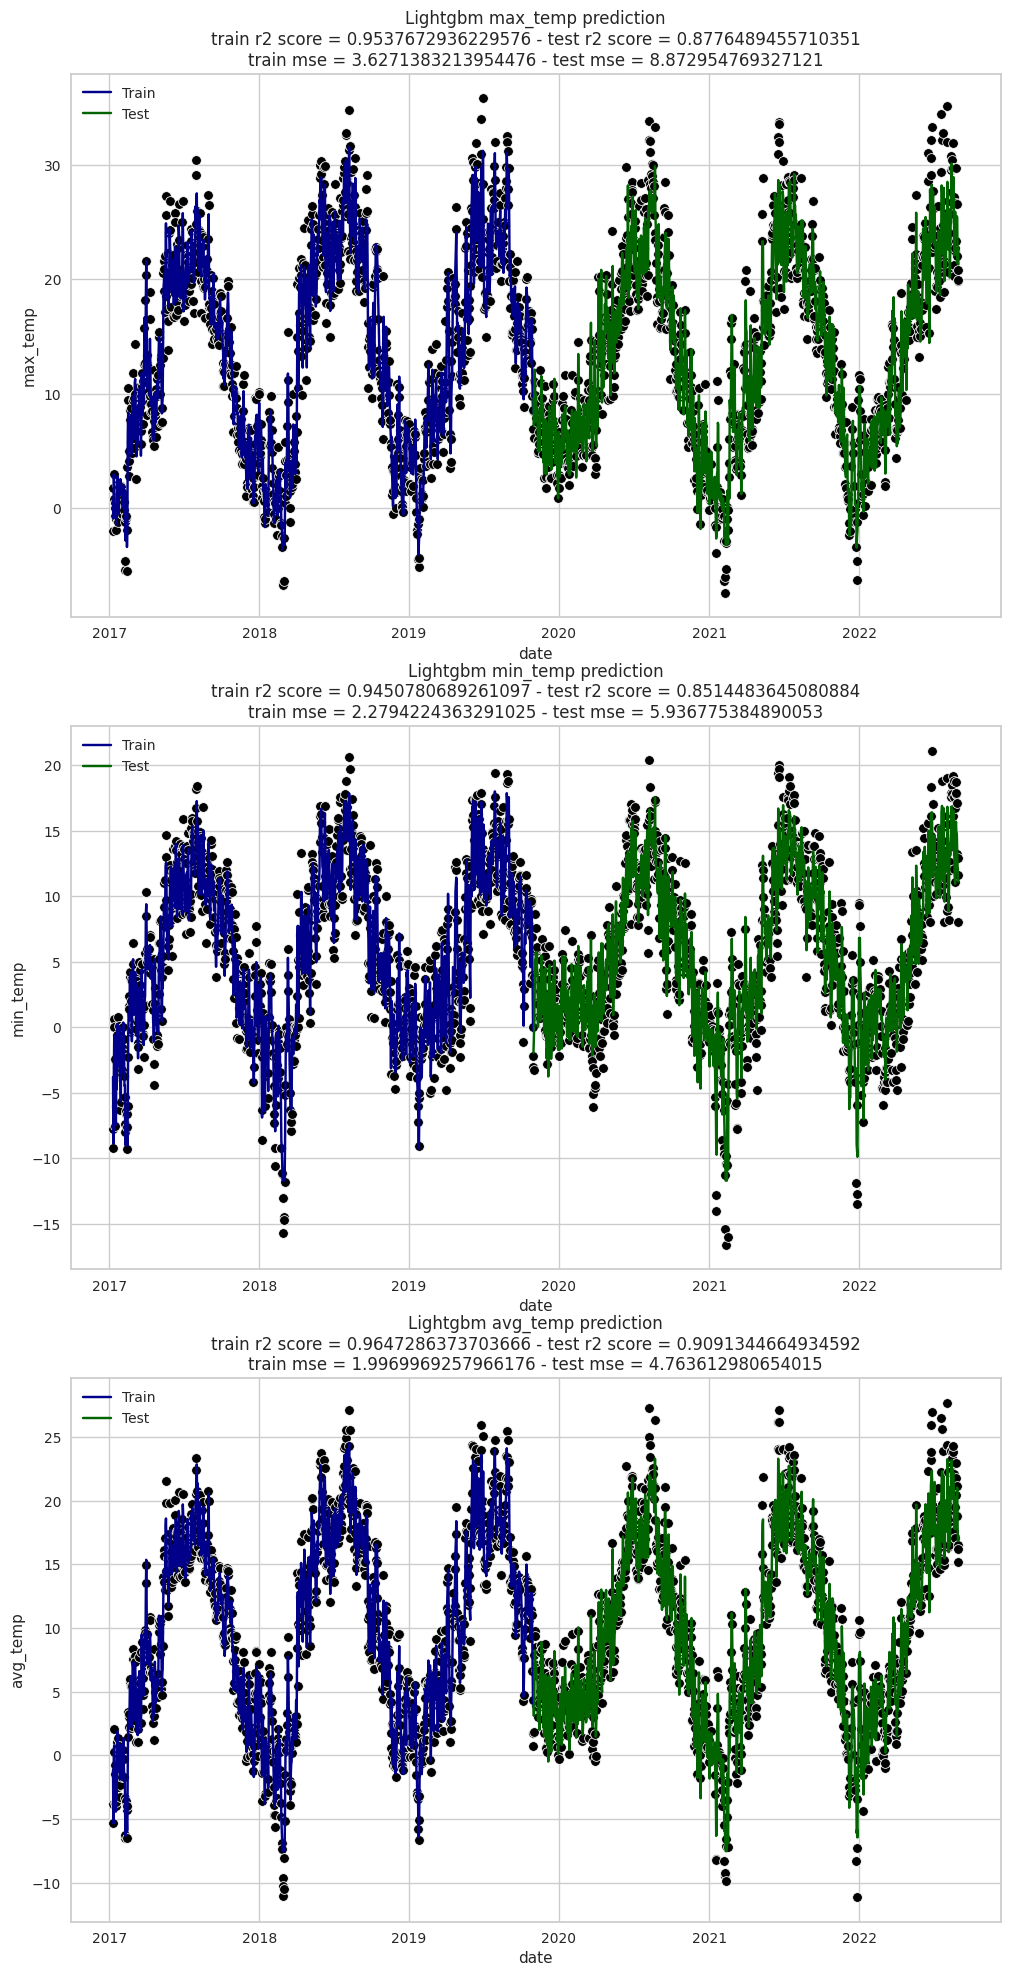

In [101]:
lgbr = LGBMRegressor(num_leaves = 13, n_estimators = 94, learning_rate = 0.11)

lgbr_multiout = MultiOutputRegressor(lgbr)

model_result(lgbr_multiout, X, y, dates, 'Lightgbm')

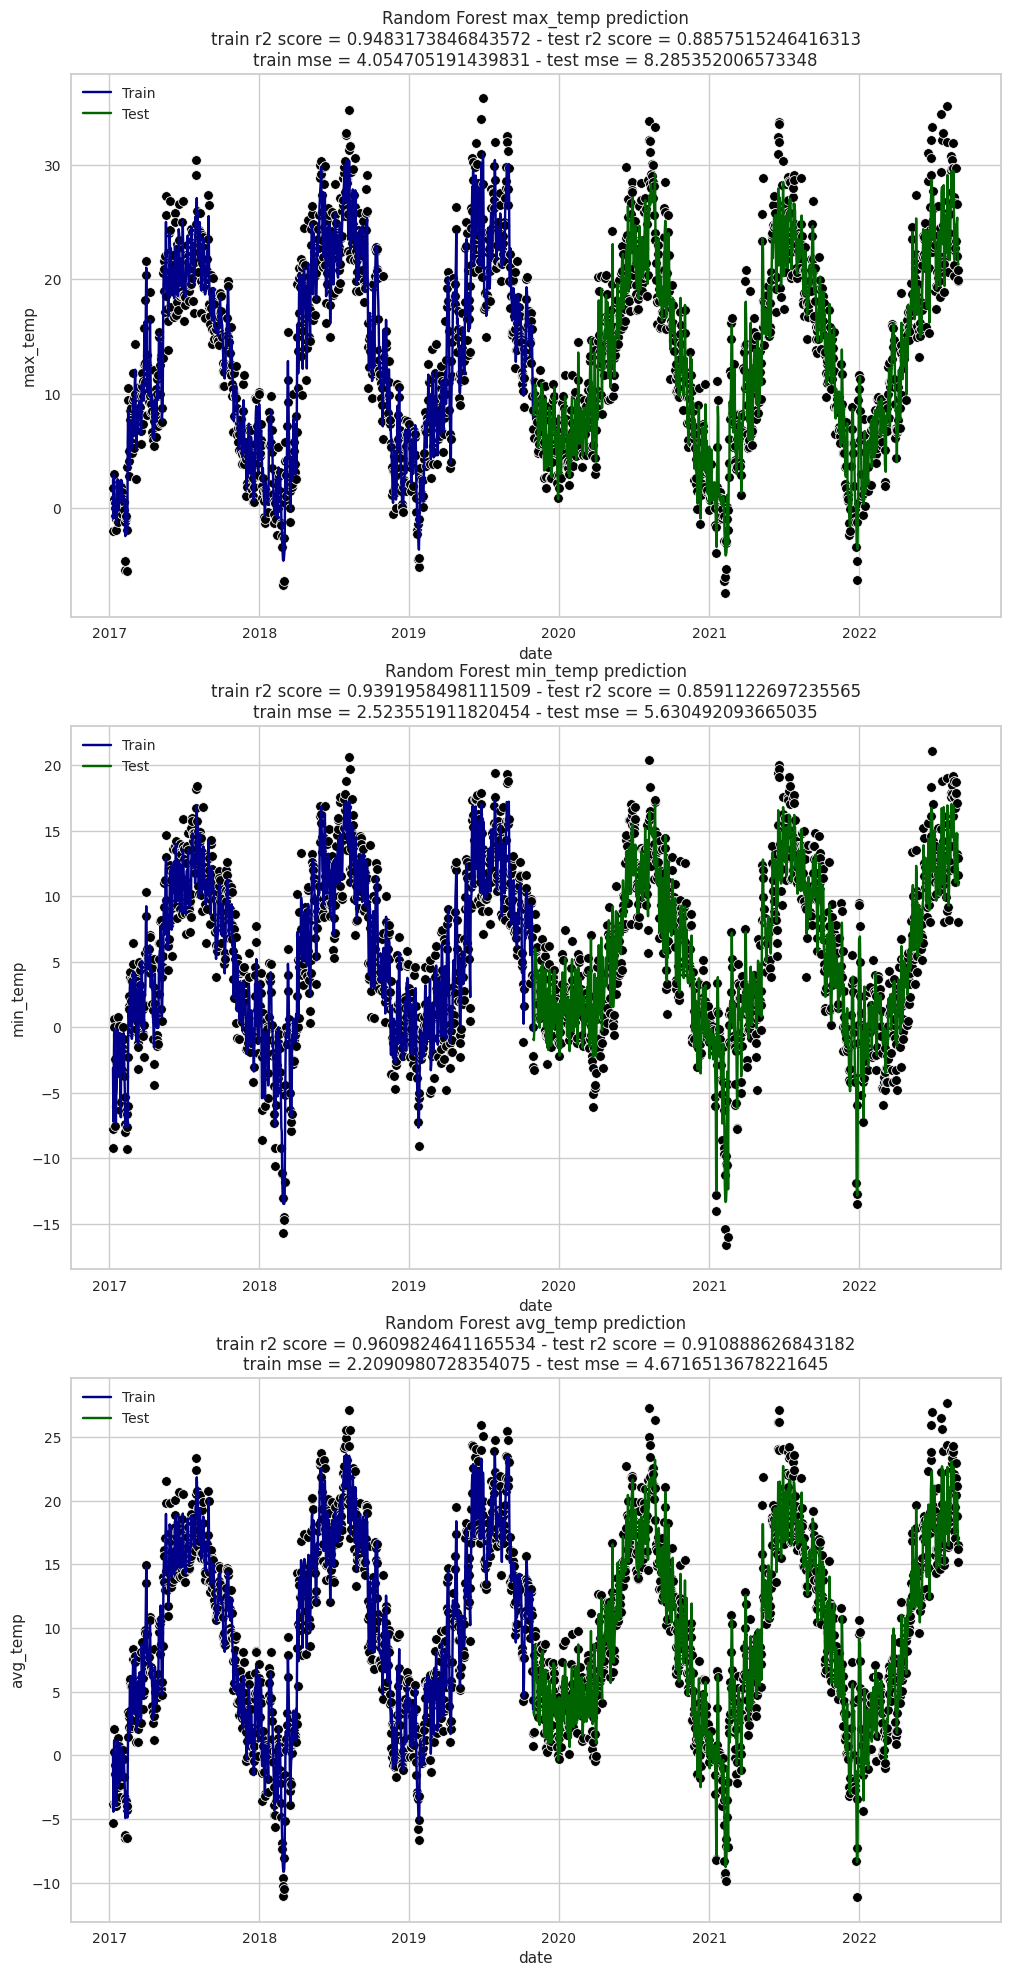

In [102]:
forest = RandomForestRegressor(random_state = 1, max_leaf_nodes = 64, n_estimators = 114, n_jobs = 4)

forest_multiout = MultiOutputRegressor(forest)

model_result(forest_multiout, X, y, dates, 'Random Forest')

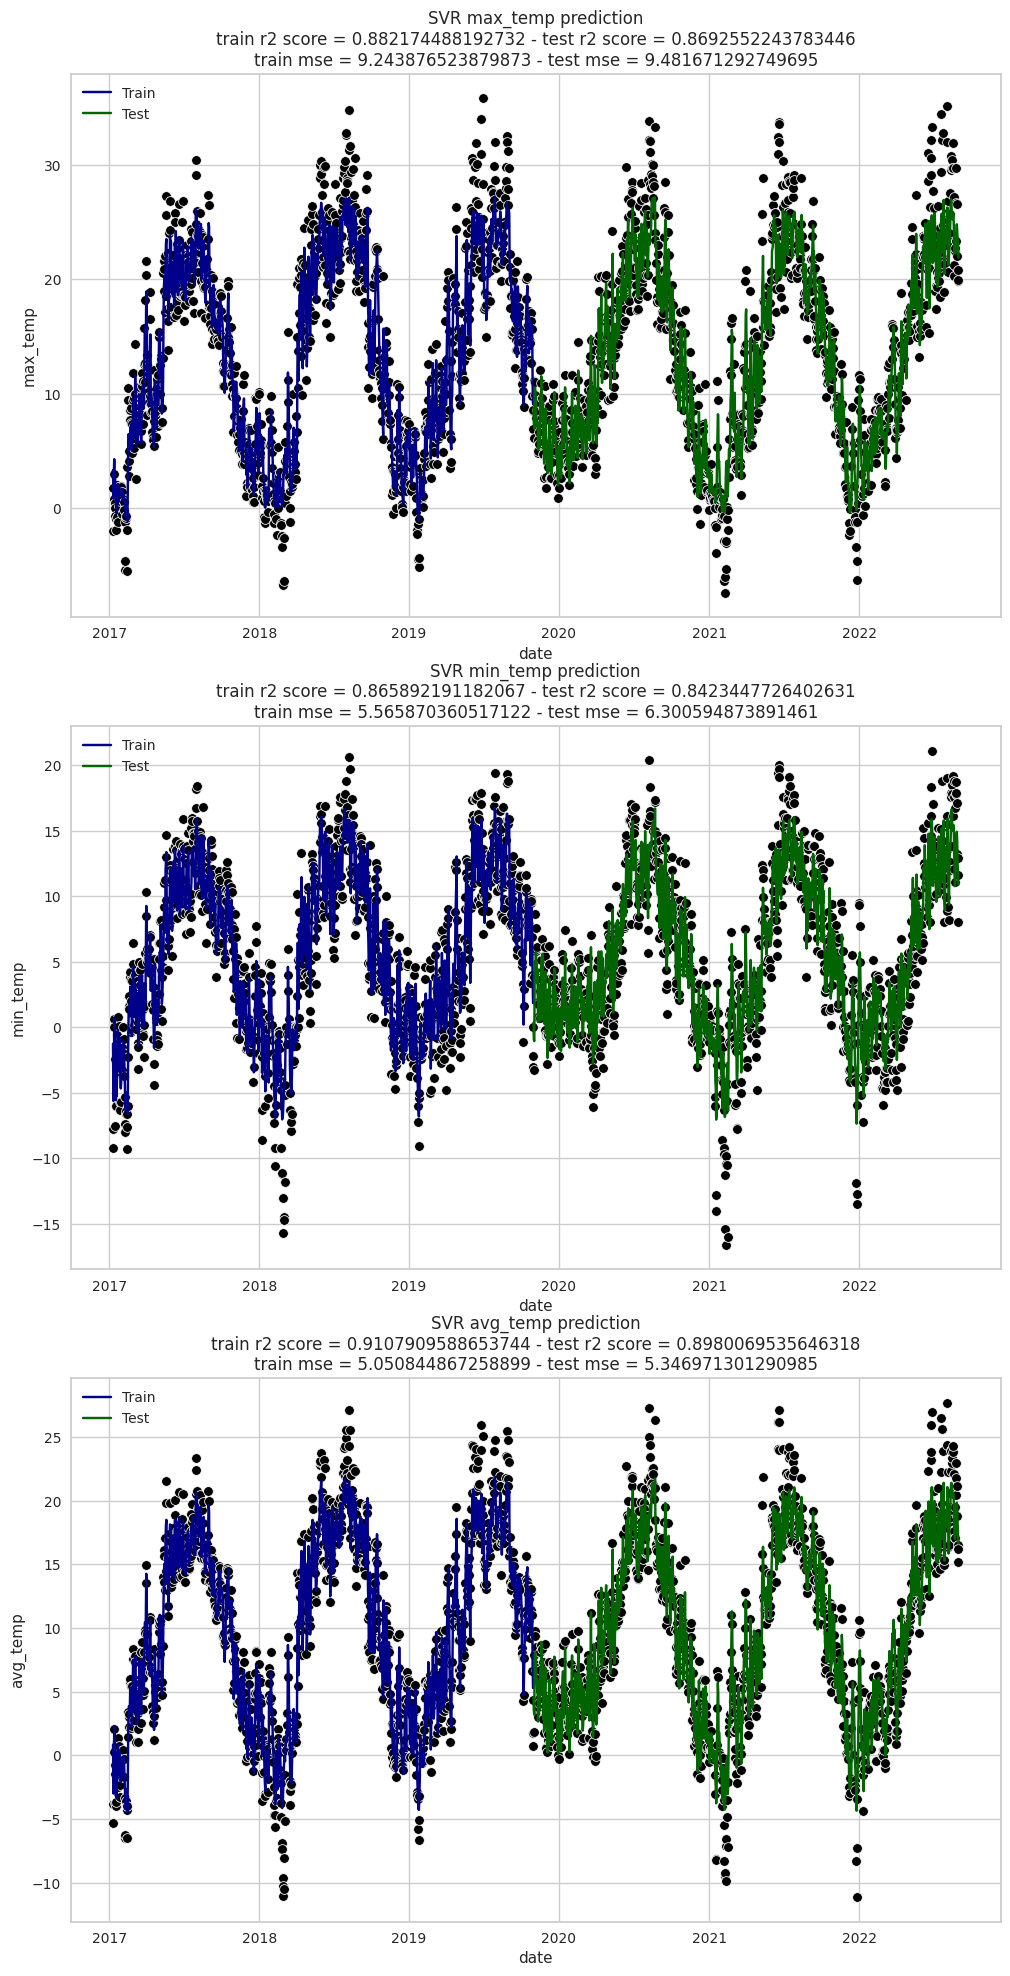

In [103]:
svr = SVR(C = 1, gamma = 0.1)

svr_multiout = MultiOutputRegressor(svr, n_jobs = 2)

model_result(svr_multiout, X, y, dates, 'SVR', scaling = True)

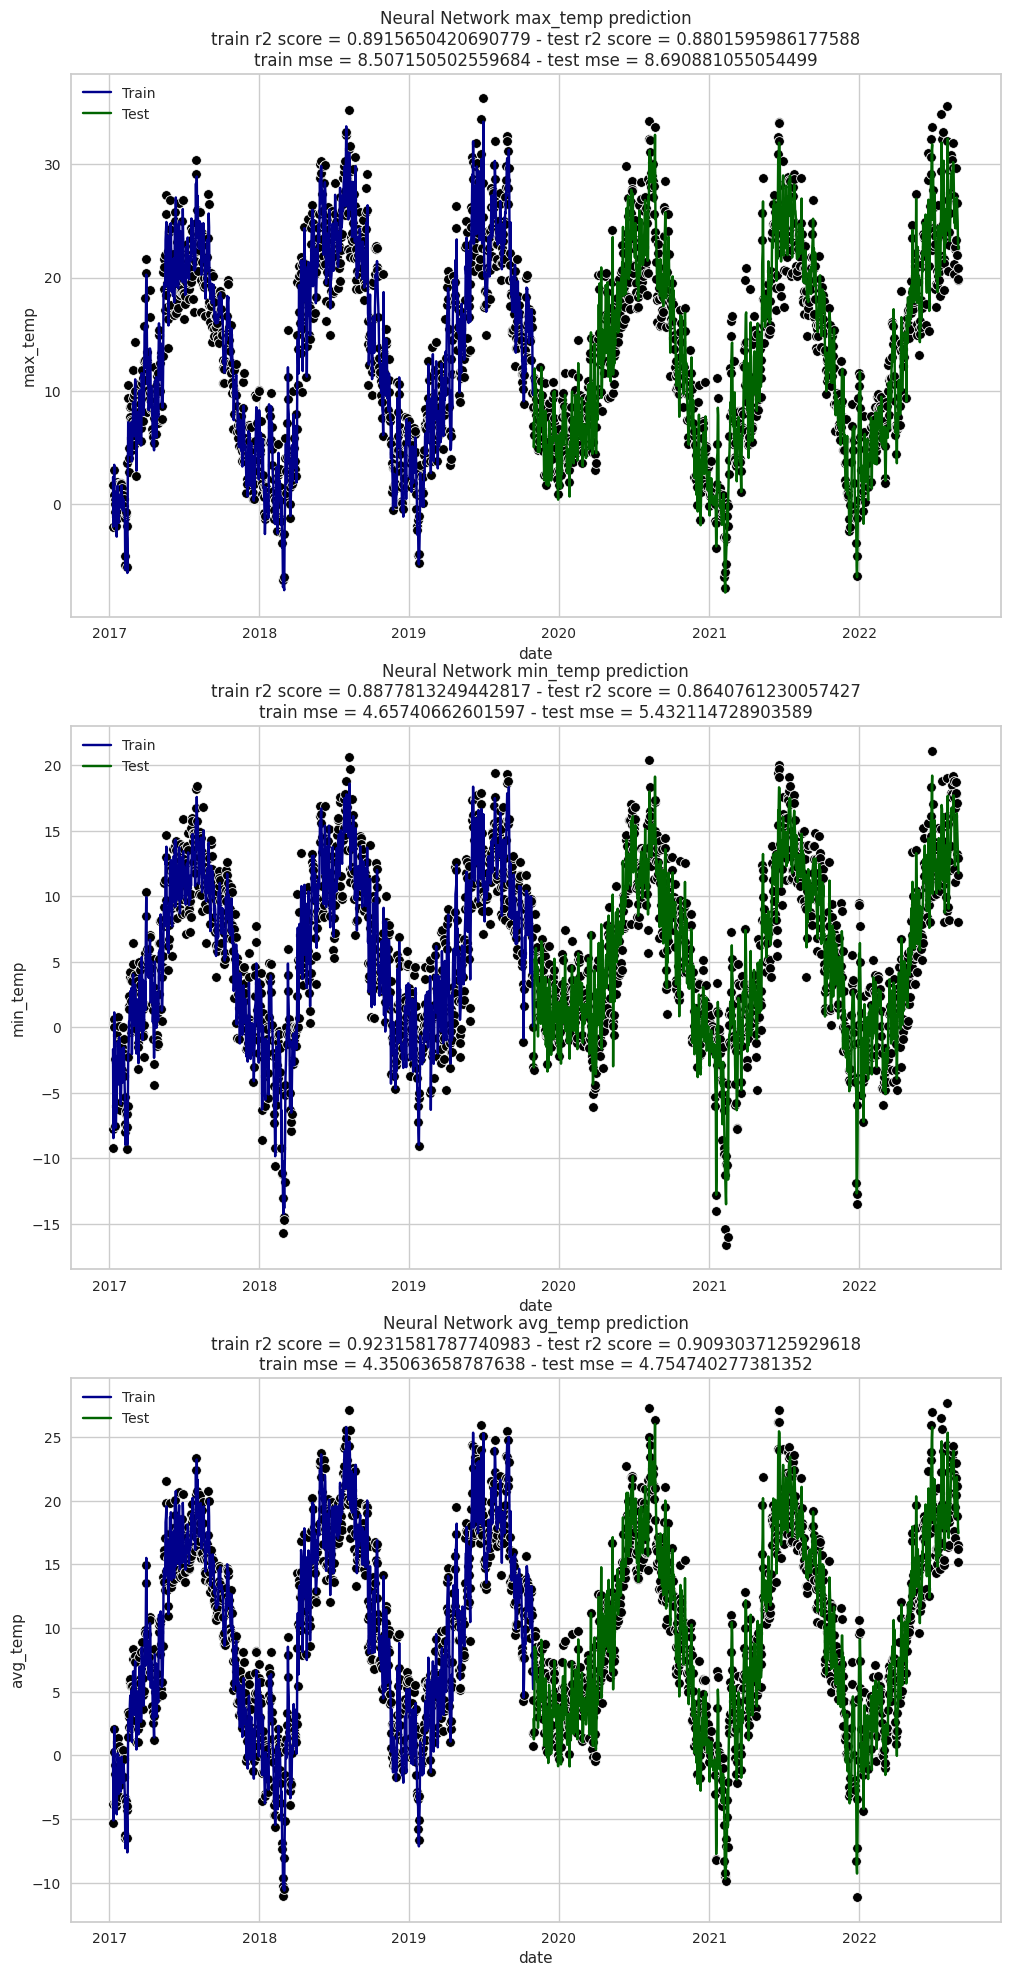

In [106]:
early_stopping = callbacks.EarlyStopping(patience = 5)

nn = Sequential([
        layers.Dense(64, input_shape = [X.shape[1]], activation = 'relu'),
        layers.Dense(16),
        layers.Dense(16),
        layers.Dense(y.shape[1])
     ])

nn.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])

scikeras_model = KerasRegressor(nn, epochs = 104, verbose = 0, callbacks = [early_stopping])

model_result(scikeras_model, X, y, dates, 'Neural Network', scaling = True)

In [107]:
def model_tables(model, X, y, dates, model_name, train_size = 0.5, scaling = False, show = True):
    size = int(X.shape[0] * train_size)
    
    train_X, test_X = splitter(X, size)
    train_y, test_y = splitter(y, size)
    
    if scaling:
        scaler = StandardScaler()
        train_X = scaler.fit_transform(train_X)
        test_X = scaler.transform(test_X)
        
    model.fit(train_X, train_y)
    
    train_pred = pd.DataFrame(model.predict(train_X), columns = y.columns)
    test_pred = pd.DataFrame(model.predict(test_X), columns = y.columns)
    model_each = {}
        
    for target, ax in zip(y.columns, axes):
        train_r2 = r2_score(train_y[target], train_pred[target])
        train_mse = mse(train_y[target], train_pred[target])
        
        test_r2 = r2_score(test_y[target], test_pred[target])
        test_mse = mse(test_y[target], test_pred[target])
    
        model_each[target] = {
            'model': model_name,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'train_mse': train_mse,
            'test_mse': test_mse
        } 
        
    return pd.DataFrame(model_each).T

In [108]:
models = [(lgbr_multiout,'Lightgbm'), (forest_multiout,'Random Forest'), (svr_multiout,'SVR'), (scikeras_model,'scikeras')]

In [109]:
scaled_table = pd.DataFrame()

for model, name in models:
    df_model = model_tables(model, X, y, dates, name, scaling = True)
    scaled_table = pd.concat([scaled_table, df_model])

display(scaled_table)

model  train_r2   test_r2 train_mse  test_mse
max_temp       Lightgbm  0.952905   0.87857  3.694814  8.806161
min_temp       Lightgbm  0.944633  0.850453  2.297905  5.976561
avg_temp       Lightgbm  0.964813  0.909251  1.992208  4.757485
max_temp  Random Forest   0.94828  0.885529  4.057673  8.301484
min_temp  Random Forest  0.939246  0.859139  2.521456  5.629411
avg_temp  Random Forest  0.960978  0.910897  2.209379  4.671197
max_temp            SVR  0.882174  0.869255  9.243877  9.481671
min_temp            SVR  0.865892  0.842345   5.56587  6.300595
avg_temp            SVR  0.910791  0.898007  5.050845  5.346971
max_temp       scikeras  0.901255  0.886638  7.746919  8.221071
min_temp       scikeras  0.894662  0.863912  4.371857  5.438684
avg_temp       scikeras  0.931762  0.913946  3.863501  4.511373

In [111]:
non_scaled_table = pd.DataFrame()

for model, name in models:
    df_model = model_tables(model, X, y, dates, name, scaling = False)
    non_scaled_table = pd.concat([non_scaled_table, df_model])

display(non_scaled_table)

model  train_r2   test_r2  train_mse   test_mse
max_temp       Lightgbm  0.953767  0.877649   3.627138   8.872955
min_temp       Lightgbm  0.945078  0.851448   2.279422   5.936775
avg_temp       Lightgbm  0.964729  0.909134   1.996997   4.763613
max_temp  Random Forest  0.948317  0.885752   4.054705   8.285352
min_temp  Random Forest  0.939196  0.859112   2.523552   5.630492
avg_temp  Random Forest  0.960982  0.910889   2.209098   4.671651
max_temp            SVR  0.338524  0.180887  51.895364  59.402477
min_temp            SVR  0.400201  0.169681  24.893446  33.183194
avg_temp            SVR  0.382004  0.195769  34.989745  42.161677
max_temp       scikeras  0.898174  0.883243   7.988688     8.4673
min_temp       scikeras  0.887943  0.863947    4.65068   5.437288
avg_temp       scikeras  0.927689  0.913113   4.094089   4.555042